In [ ]:
## Setup and Data Loading

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import os
from pathlib import Path

import sys
sys.path.insert(0, '../..')

from ab.stat.util.Const import png_dir_raw, png_dir_stat, raw_xlsx

In [2]:
# Uncomment the next 2 lines if you need to import data from database and generate/update Excel file
# import ab.stat.export as export_data_to_excel
# export_data_to_excel.main()

# Set plot style for publication-quality graphics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'

# Read the data
print("Loading data...")
df = pd.read_excel(raw_xlsx)
print(f"Data loaded. Shape: {df.shape}")

# Display the first few rows to understand the data structure
df.head()


Loading data...
Data loaded. Shape: (39386, 12)


task        dataset metric  epoch      duration  accuracy  \
0  img-classification  celeba-gender    acc      1  4.711268e+10  0.967739   
1  img-classification  celeba-gender    acc      1  4.415546e+10  0.964432   
2  img-classification  celeba-gender    acc      1  3.954598e+11  0.963931   
3  img-classification  celeba-gender    acc      1  1.023431e+11  0.962429   
4  img-classification  celeba-gender    acc      1  1.648104e+11  0.949354   

       nn  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10         Unnamed: 11  
0  AirNet         NaN         NaN         NaN          NaN  Accuracy vs Epochs  
1  AirNet         NaN         NaN         NaN          NaN                 NaN  
2  AirNet         NaN         NaN         NaN          NaN                 NaN  
3  AirNet         NaN         NaN         NaN          NaN                 NaN  
4  AirNet         NaN         NaN         NaN          NaN                 NaN

In [3]:
## Data Filtering and Preparation

# Filter for relevant models and datasets
relevant_models = [
    'AirNet', 'AirNext', 'BagNet', 'DarkNet', 'Diffuser', 'DPN68', 'DPN131', 'DPN107', 'FractalNet', 'ICNet'
]

relevant_datasets = [
    'celeba-gender', 'cifar-10', 'cifar-100', 'mnist', 'places365', 'svhn', 'imagenette'
]

filtered_df = df[(df['nn'].isin(relevant_models)) & (df['dataset'].isin(relevant_datasets))]
filtered_df['duration_seconds'] = filtered_df['duration'] / 1e9
print(f"Filtered data shape: {filtered_df.shape}")

# Define color palette for consistent colors across visualizations
model_colors = dict(zip(relevant_models, sns.color_palette("tab10", len(relevant_models))))

# Look at the filtered data
filtered_df.head()


Filtered data shape: (9399, 13)


/tmp/ipykernel_295280/2635945617.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['duration_seconds'] = filtered_df['duration'] / 1e9


task        dataset metric  epoch      duration  accuracy  \
0  img-classification  celeba-gender    acc      1  4.711268e+10  0.967739   
1  img-classification  celeba-gender    acc      1  4.415546e+10  0.964432   
2  img-classification  celeba-gender    acc      1  3.954598e+11  0.963931   
3  img-classification  celeba-gender    acc      1  1.023431e+11  0.962429   
4  img-classification  celeba-gender    acc      1  1.648104e+11  0.949354   

       nn  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  \
0  AirNet         NaN         NaN         NaN          NaN   
1  AirNet         NaN         NaN         NaN          NaN   
2  AirNet         NaN         NaN         NaN          NaN   
3  AirNet         NaN         NaN         NaN          NaN   
4  AirNet         NaN         NaN         NaN          NaN   

          Unnamed: 11  duration_seconds  
0  Accuracy vs Epochs         47.112679  
1                 NaN         44.155458  
2                 NaN        395.459753  
3                 NaN        102.343140  
4                 NaN        164.810424

Creating performance overview visualization...


/tmp/ipykernel_295280/1880777406.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_accuracy.index, y=model_accuracy.values, palette=[model_colors[m] for m in model_accuracy.index])


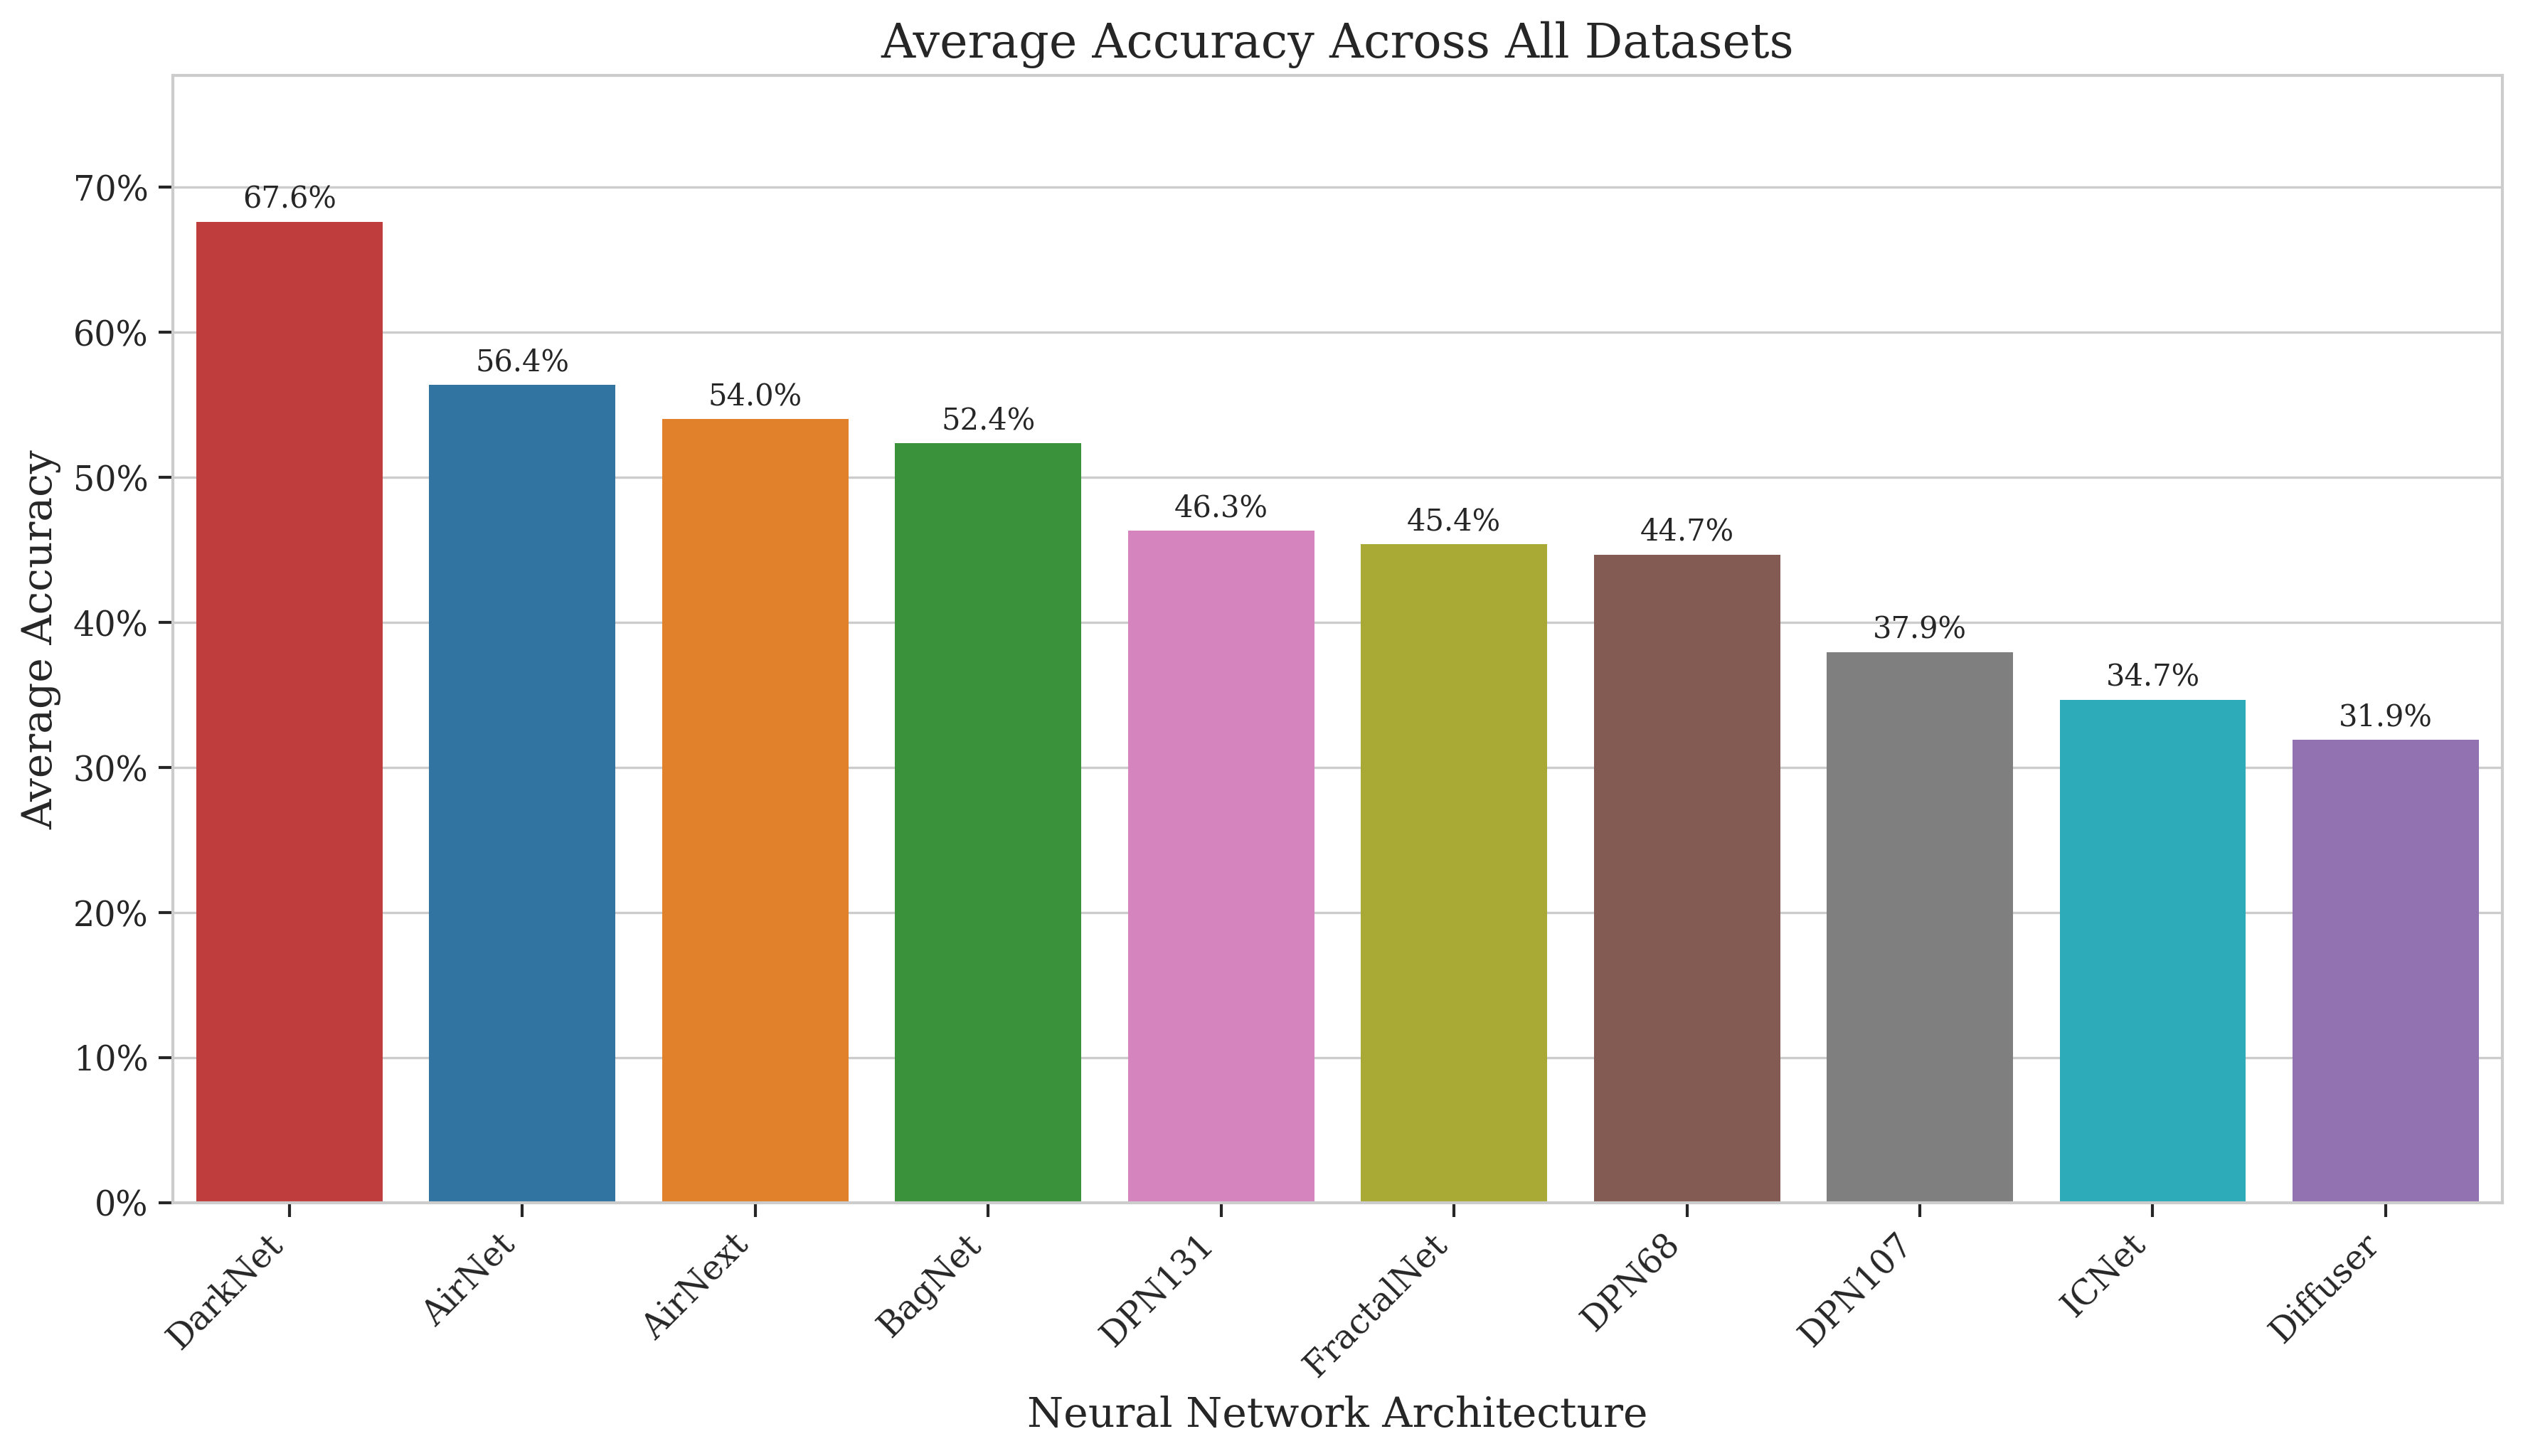

In [4]:
## Visualization 1: Overall Performance Comparison


def create_performance_overview():
    print("Creating performance overview visualization...")
    model_accuracy = filtered_df.groupby('nn')['accuracy'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=model_accuracy.index, y=model_accuracy.values, palette=[model_colors[m] for m in model_accuracy.index])
    
    plt.title('Average Accuracy Across All Datasets', fontsize=16)
    plt.xlabel('Neural Network Architecture', fontsize=14)
    plt.ylabel('Average Accuracy', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage formatting to y-axis
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Add value labels
    for i, v in enumerate(model_accuracy.values):
        ax.text(i, v + 0.01, f"{v:.1%}", ha='center', fontsize=10)
    
    plt.ylim(0, max(model_accuracy.values) * 1.15)  # Add some space for labels
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'overall_performance.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_performance_overview()

Creating dataset performance heatmap...


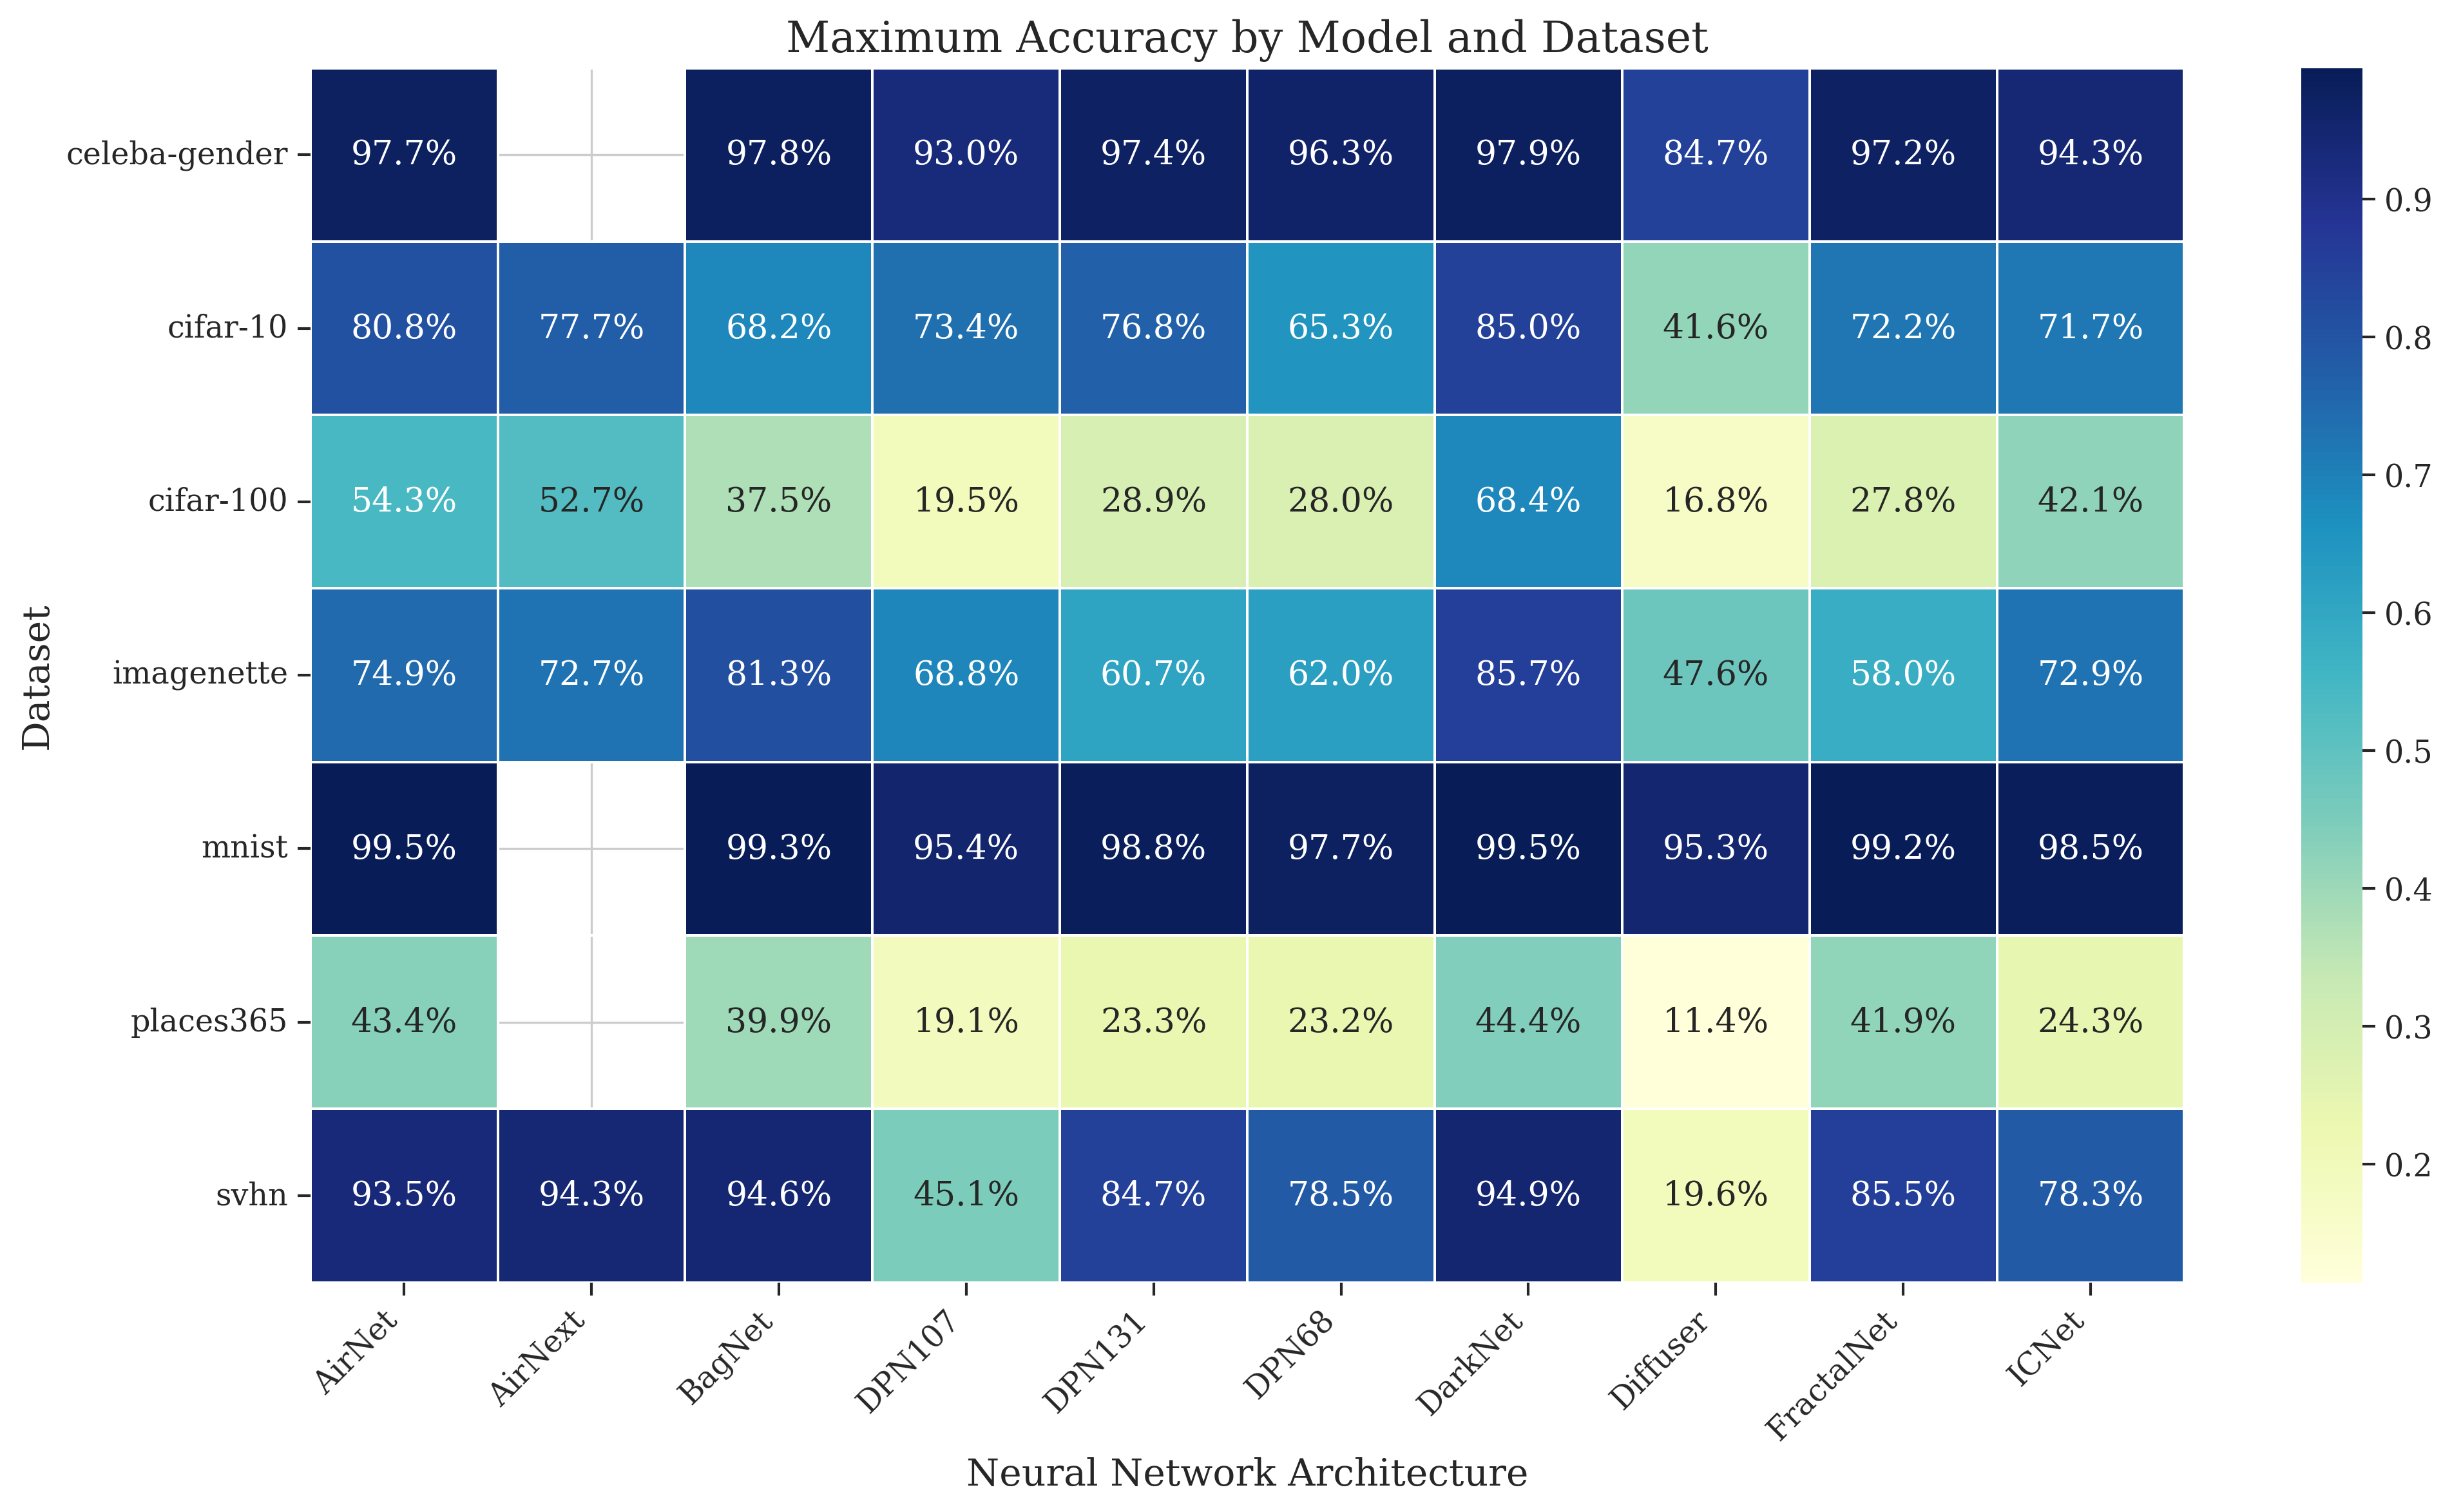

In [5]:
## Visualization 2: Performance by Dataset - Heatmap

def create_dataset_heatmap():
    print("Creating dataset performance heatmap...")
    pivot_data = filtered_df.pivot_table(
        index='dataset', 
        columns='nn', 
        values='accuracy', 
        aggfunc='max'
    )
    
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(pivot_data, annot=True, fmt='.1%', cmap='YlGnBu', linewidths=0.5)
    
    plt.title('Maximum Accuracy by Model and Dataset', fontsize=16)
    plt.xlabel('Neural Network Architecture', fontsize=14)
    plt.ylabel('Dataset', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'dataset_heatmap.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_dataset_heatmap()

Creating training efficiency visualization...


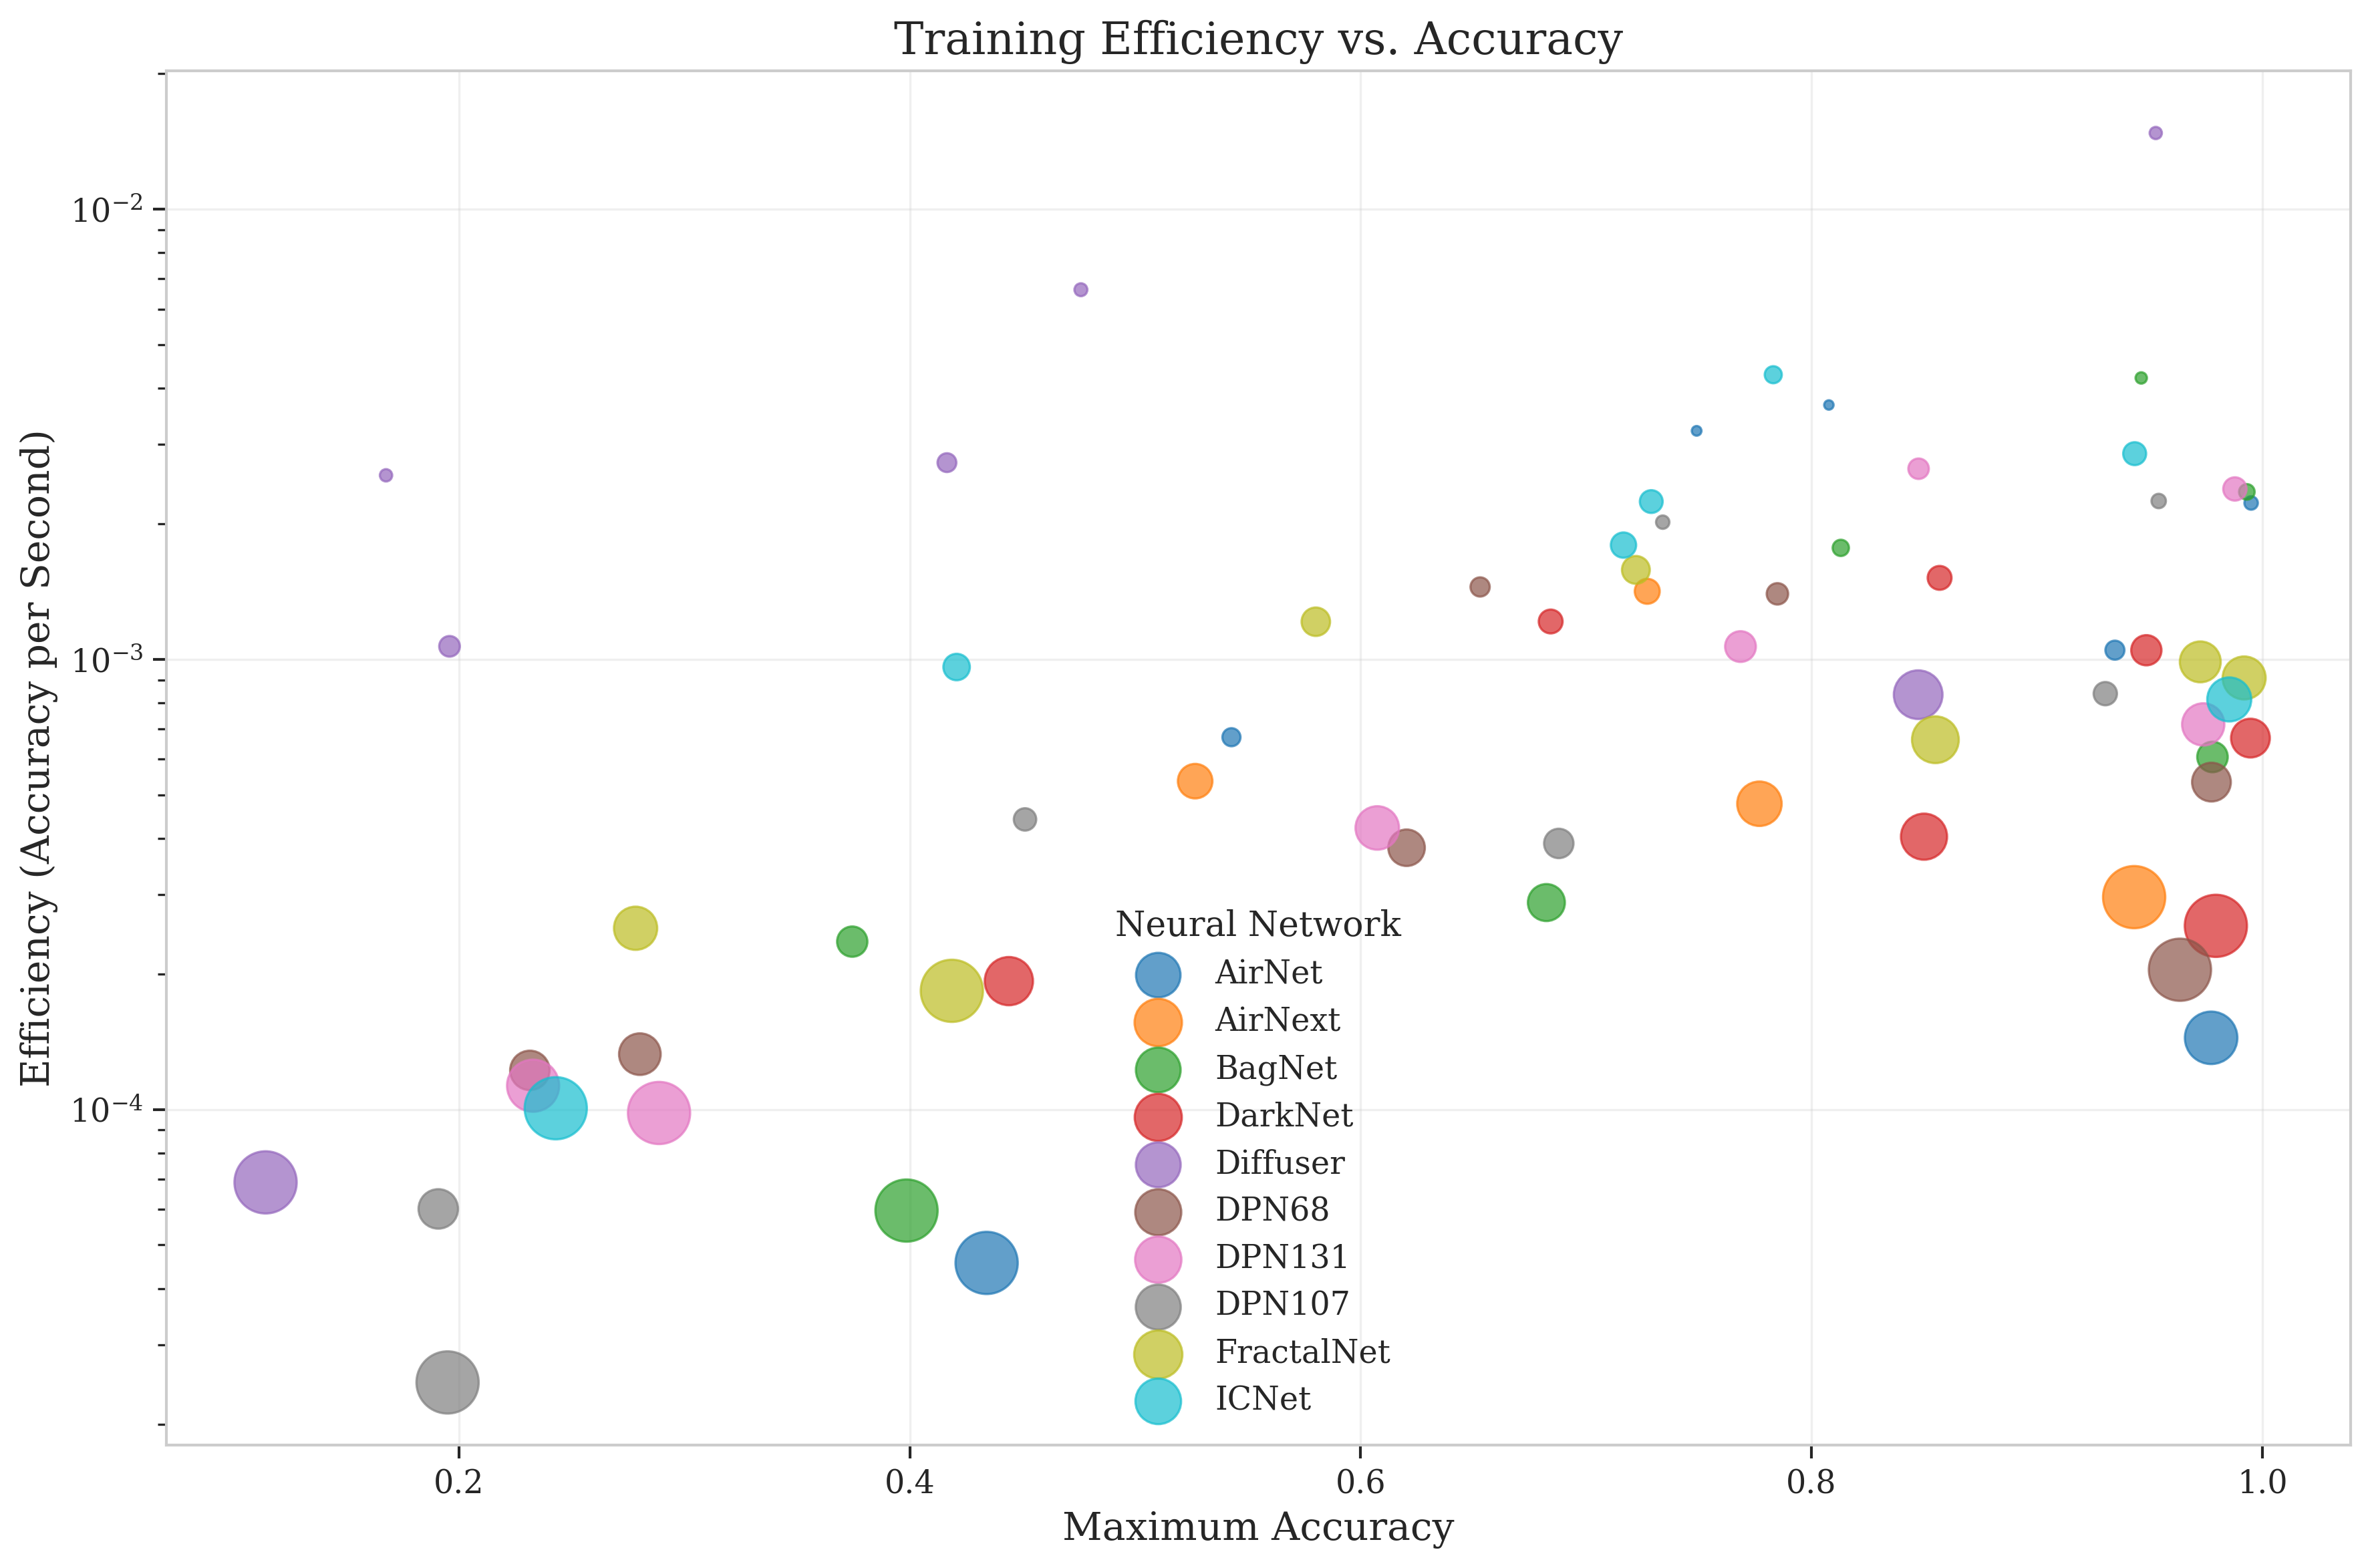

In [6]:
## Visualization 3: Training Efficiency

def create_efficiency_visualization():
    print("Creating training efficiency visualization...")
    # Calculate efficiency as accuracy per training second
    efficiency_data = []
    
    for (nn, dataset), group in filtered_df.groupby(['nn', 'dataset']):
        max_accuracy = group['accuracy'].max()
        avg_duration = group['duration_seconds'].mean()
        
        if not pd.isna(avg_duration) and avg_duration > 0:
            efficiency = max_accuracy / avg_duration
            efficiency_data.append({
                'nn': nn,
                'dataset': dataset,
                'efficiency': efficiency,
                'max_accuracy': max_accuracy,
                'avg_duration': avg_duration
            })
    
    efficiency_df = pd.DataFrame(efficiency_data)
    
    # Create bubble chart - efficiency vs accuracy with size as duration
    plt.figure(figsize=(12, 8))
    
    for nn in relevant_models:
        model_data = efficiency_df[efficiency_df['nn'] == nn]
        if not model_data.empty:
            sizes = model_data['avg_duration'] / model_data['avg_duration'].max() * 500
            plt.scatter(
                model_data['max_accuracy'], 
                model_data['efficiency'],
                s=sizes,
                alpha=0.7,
                label=nn,
                color=model_colors.get(nn)
            )
    
    plt.title('Training Efficiency vs. Accuracy', fontsize=16)
    plt.xlabel('Maximum Accuracy', fontsize=14)
    plt.ylabel('Efficiency (Accuracy per Second)', fontsize=14)
    plt.xscale('linear')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Neural Network')
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'training_efficiency.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_efficiency_visualization()

Creating learning curves for each dataset...


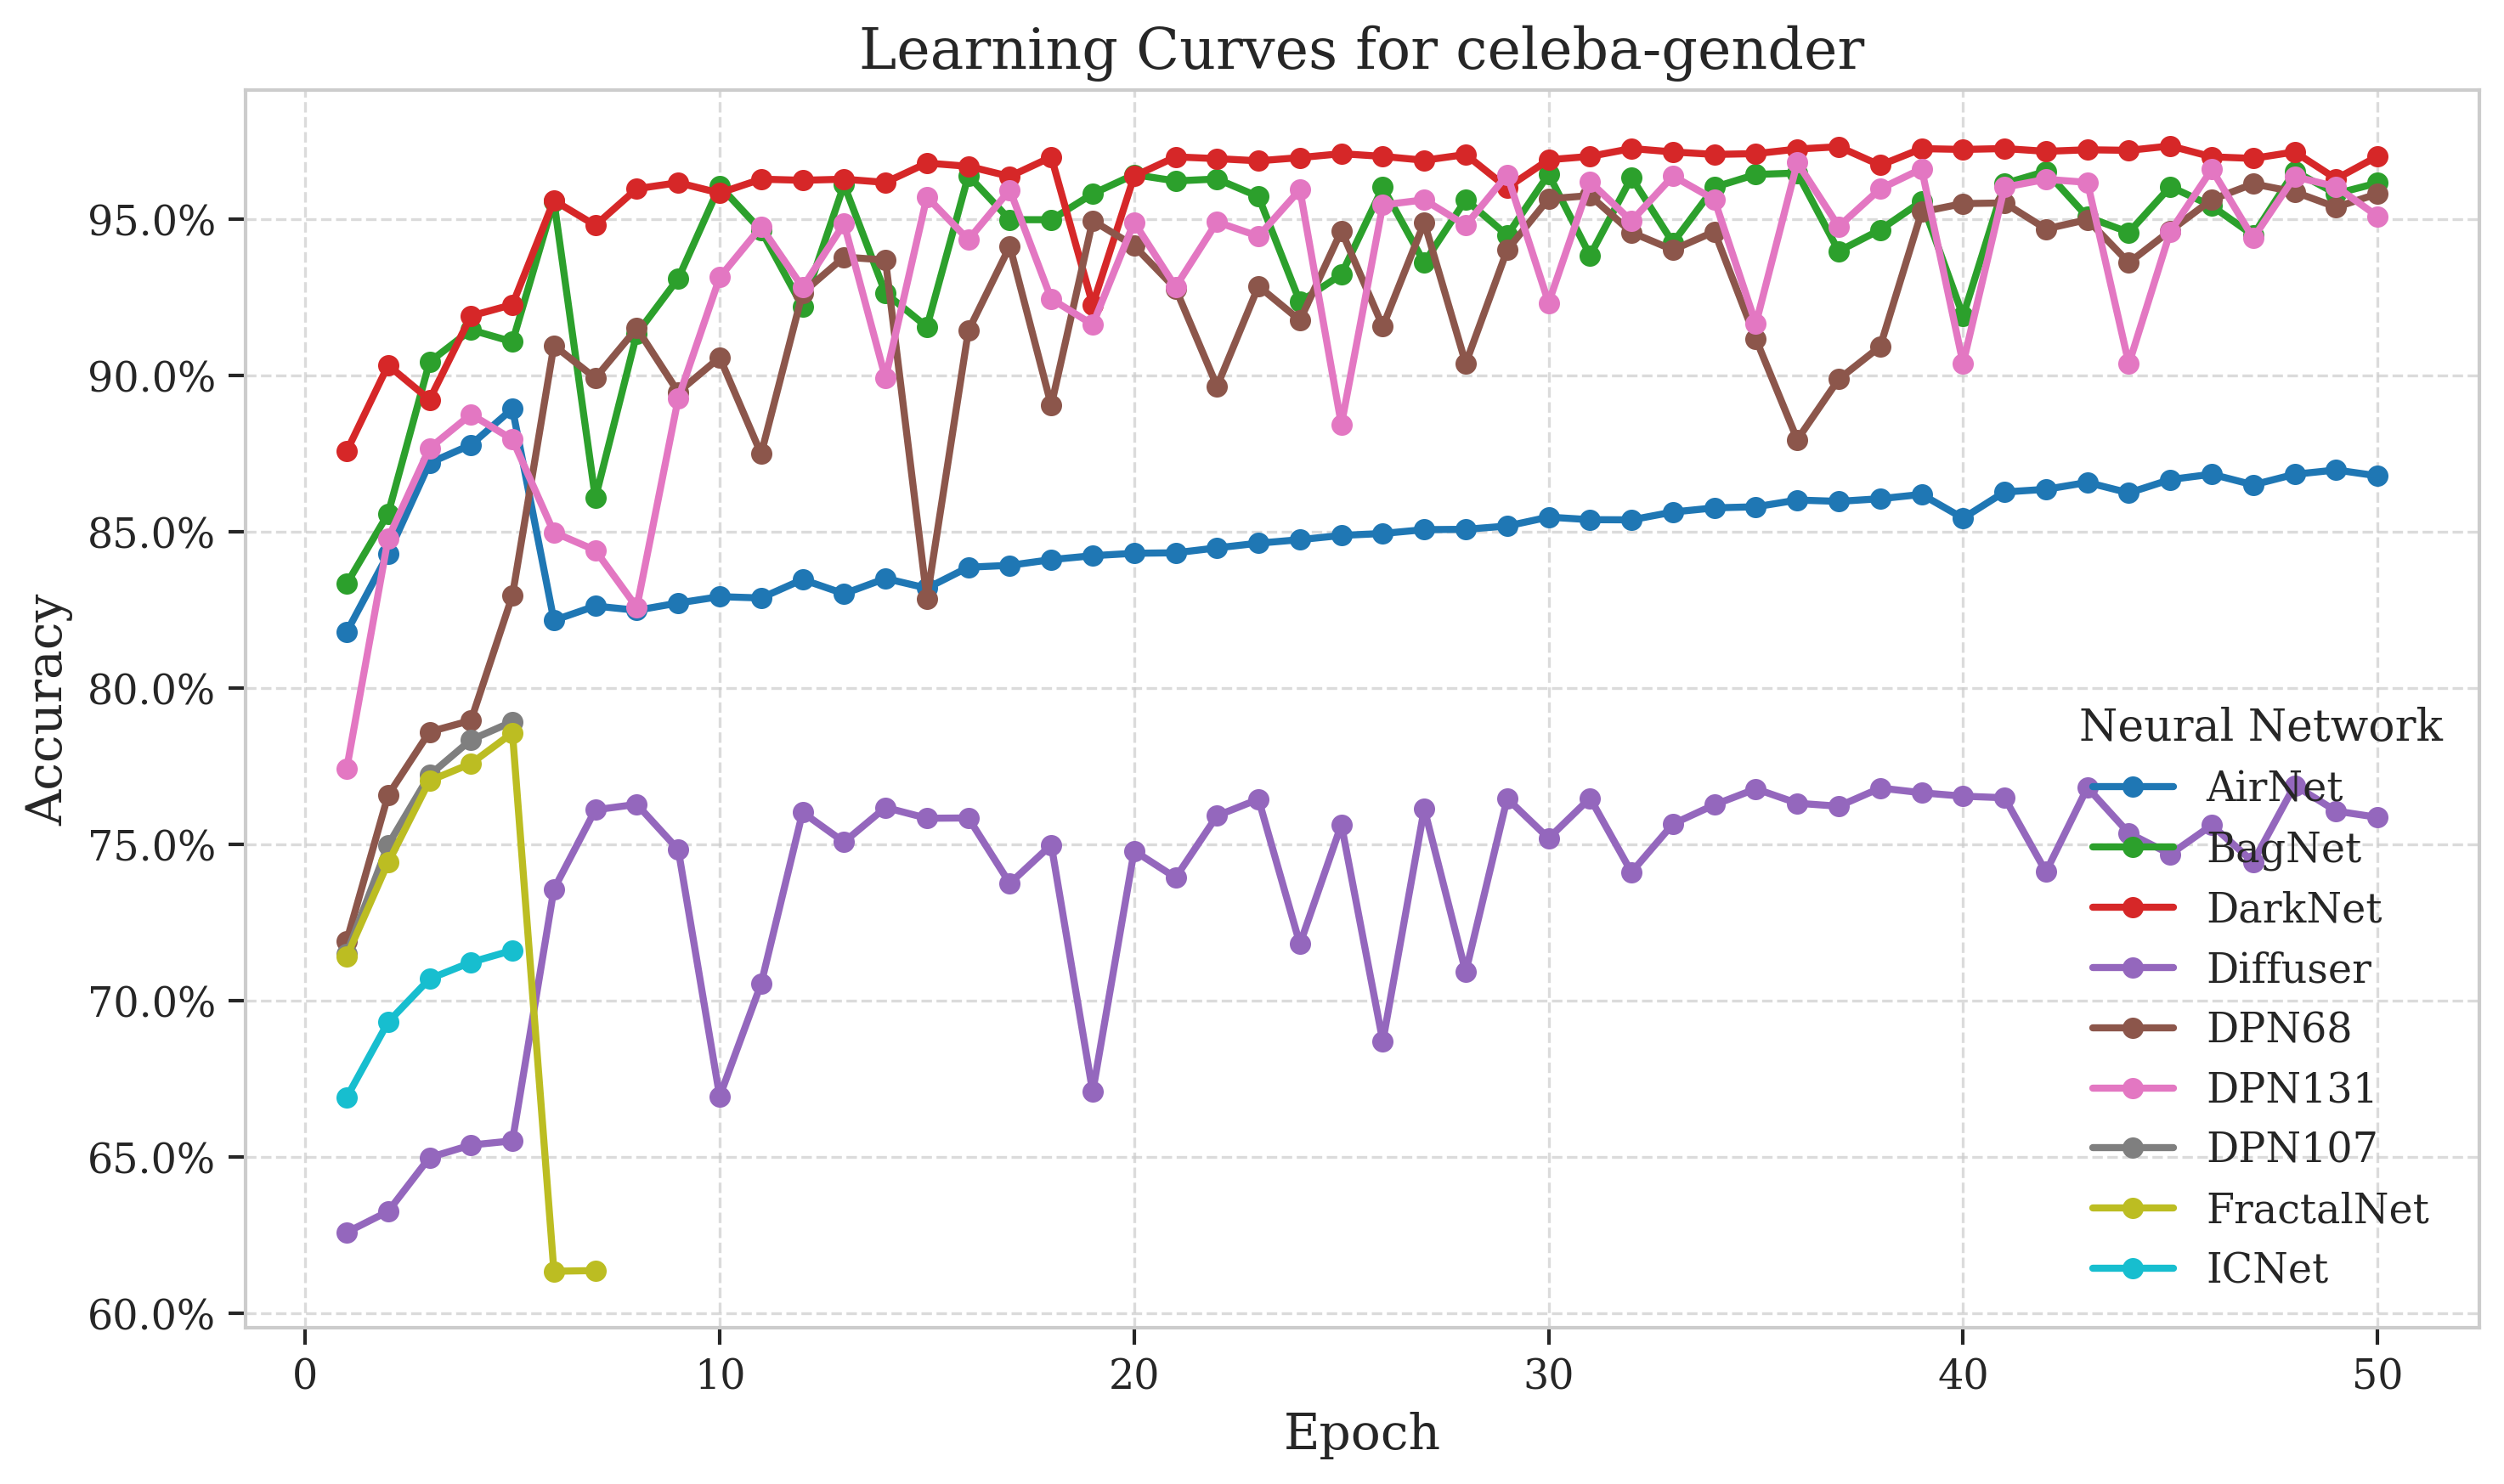

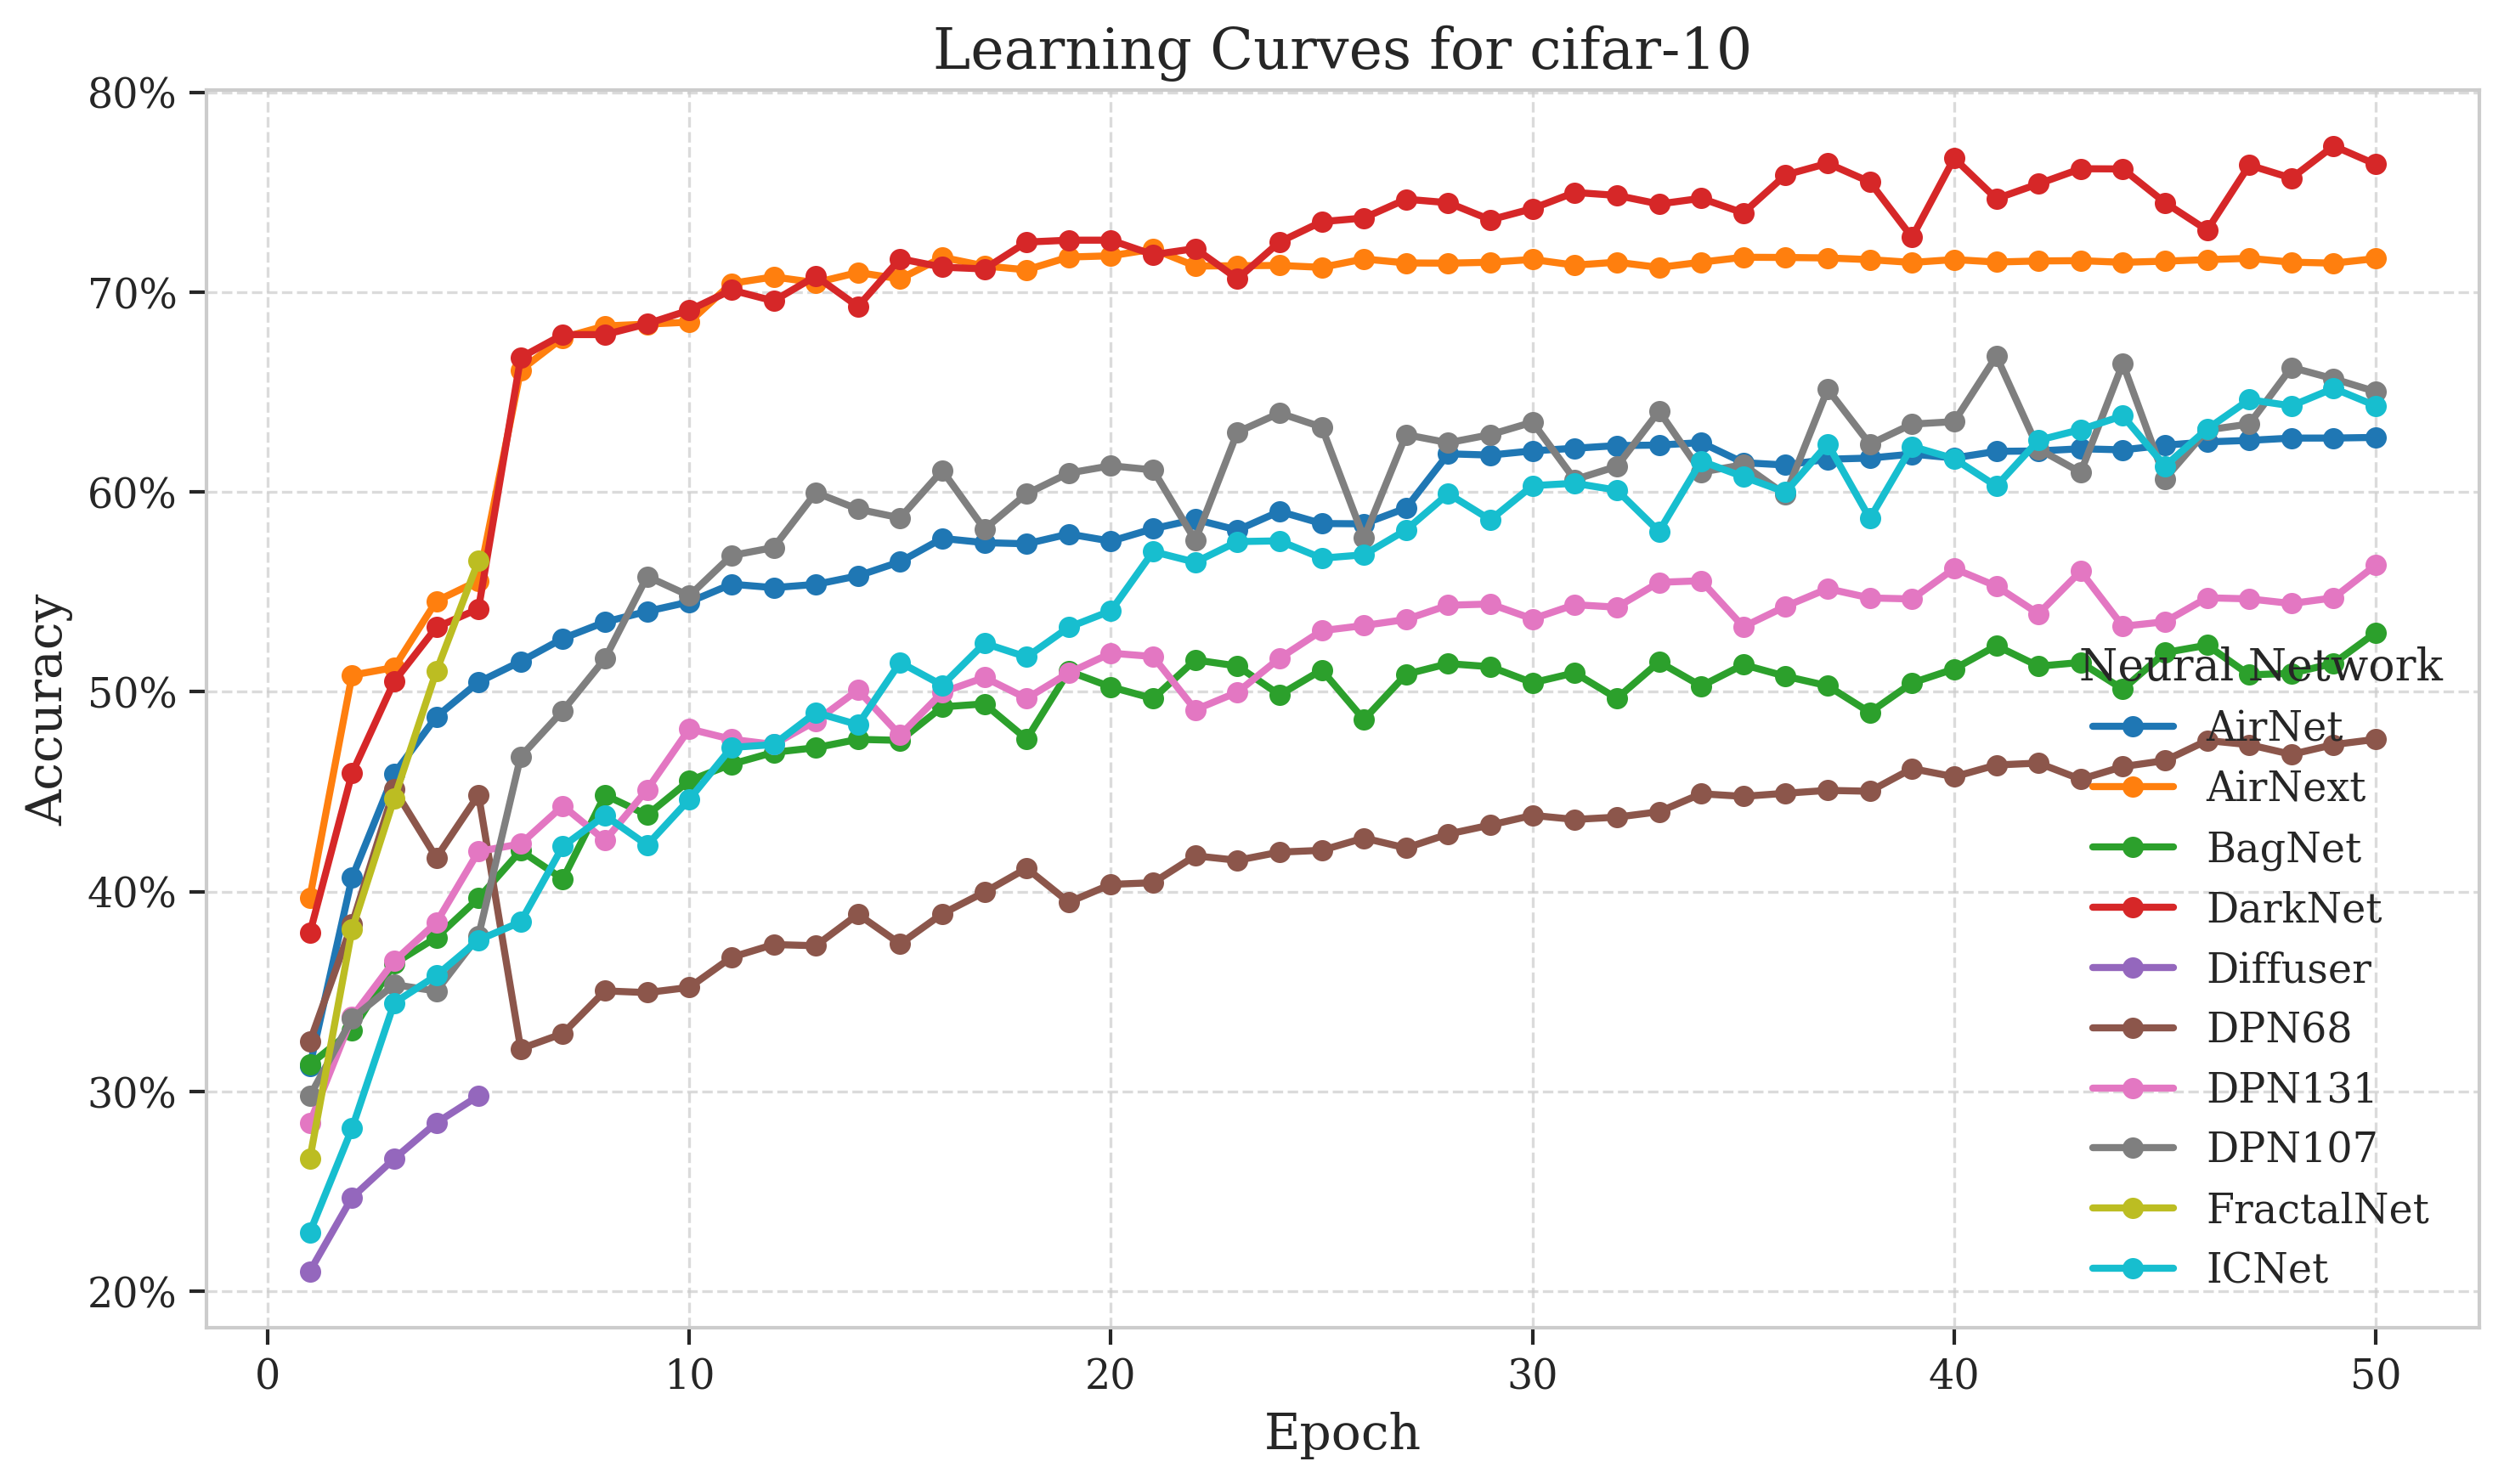

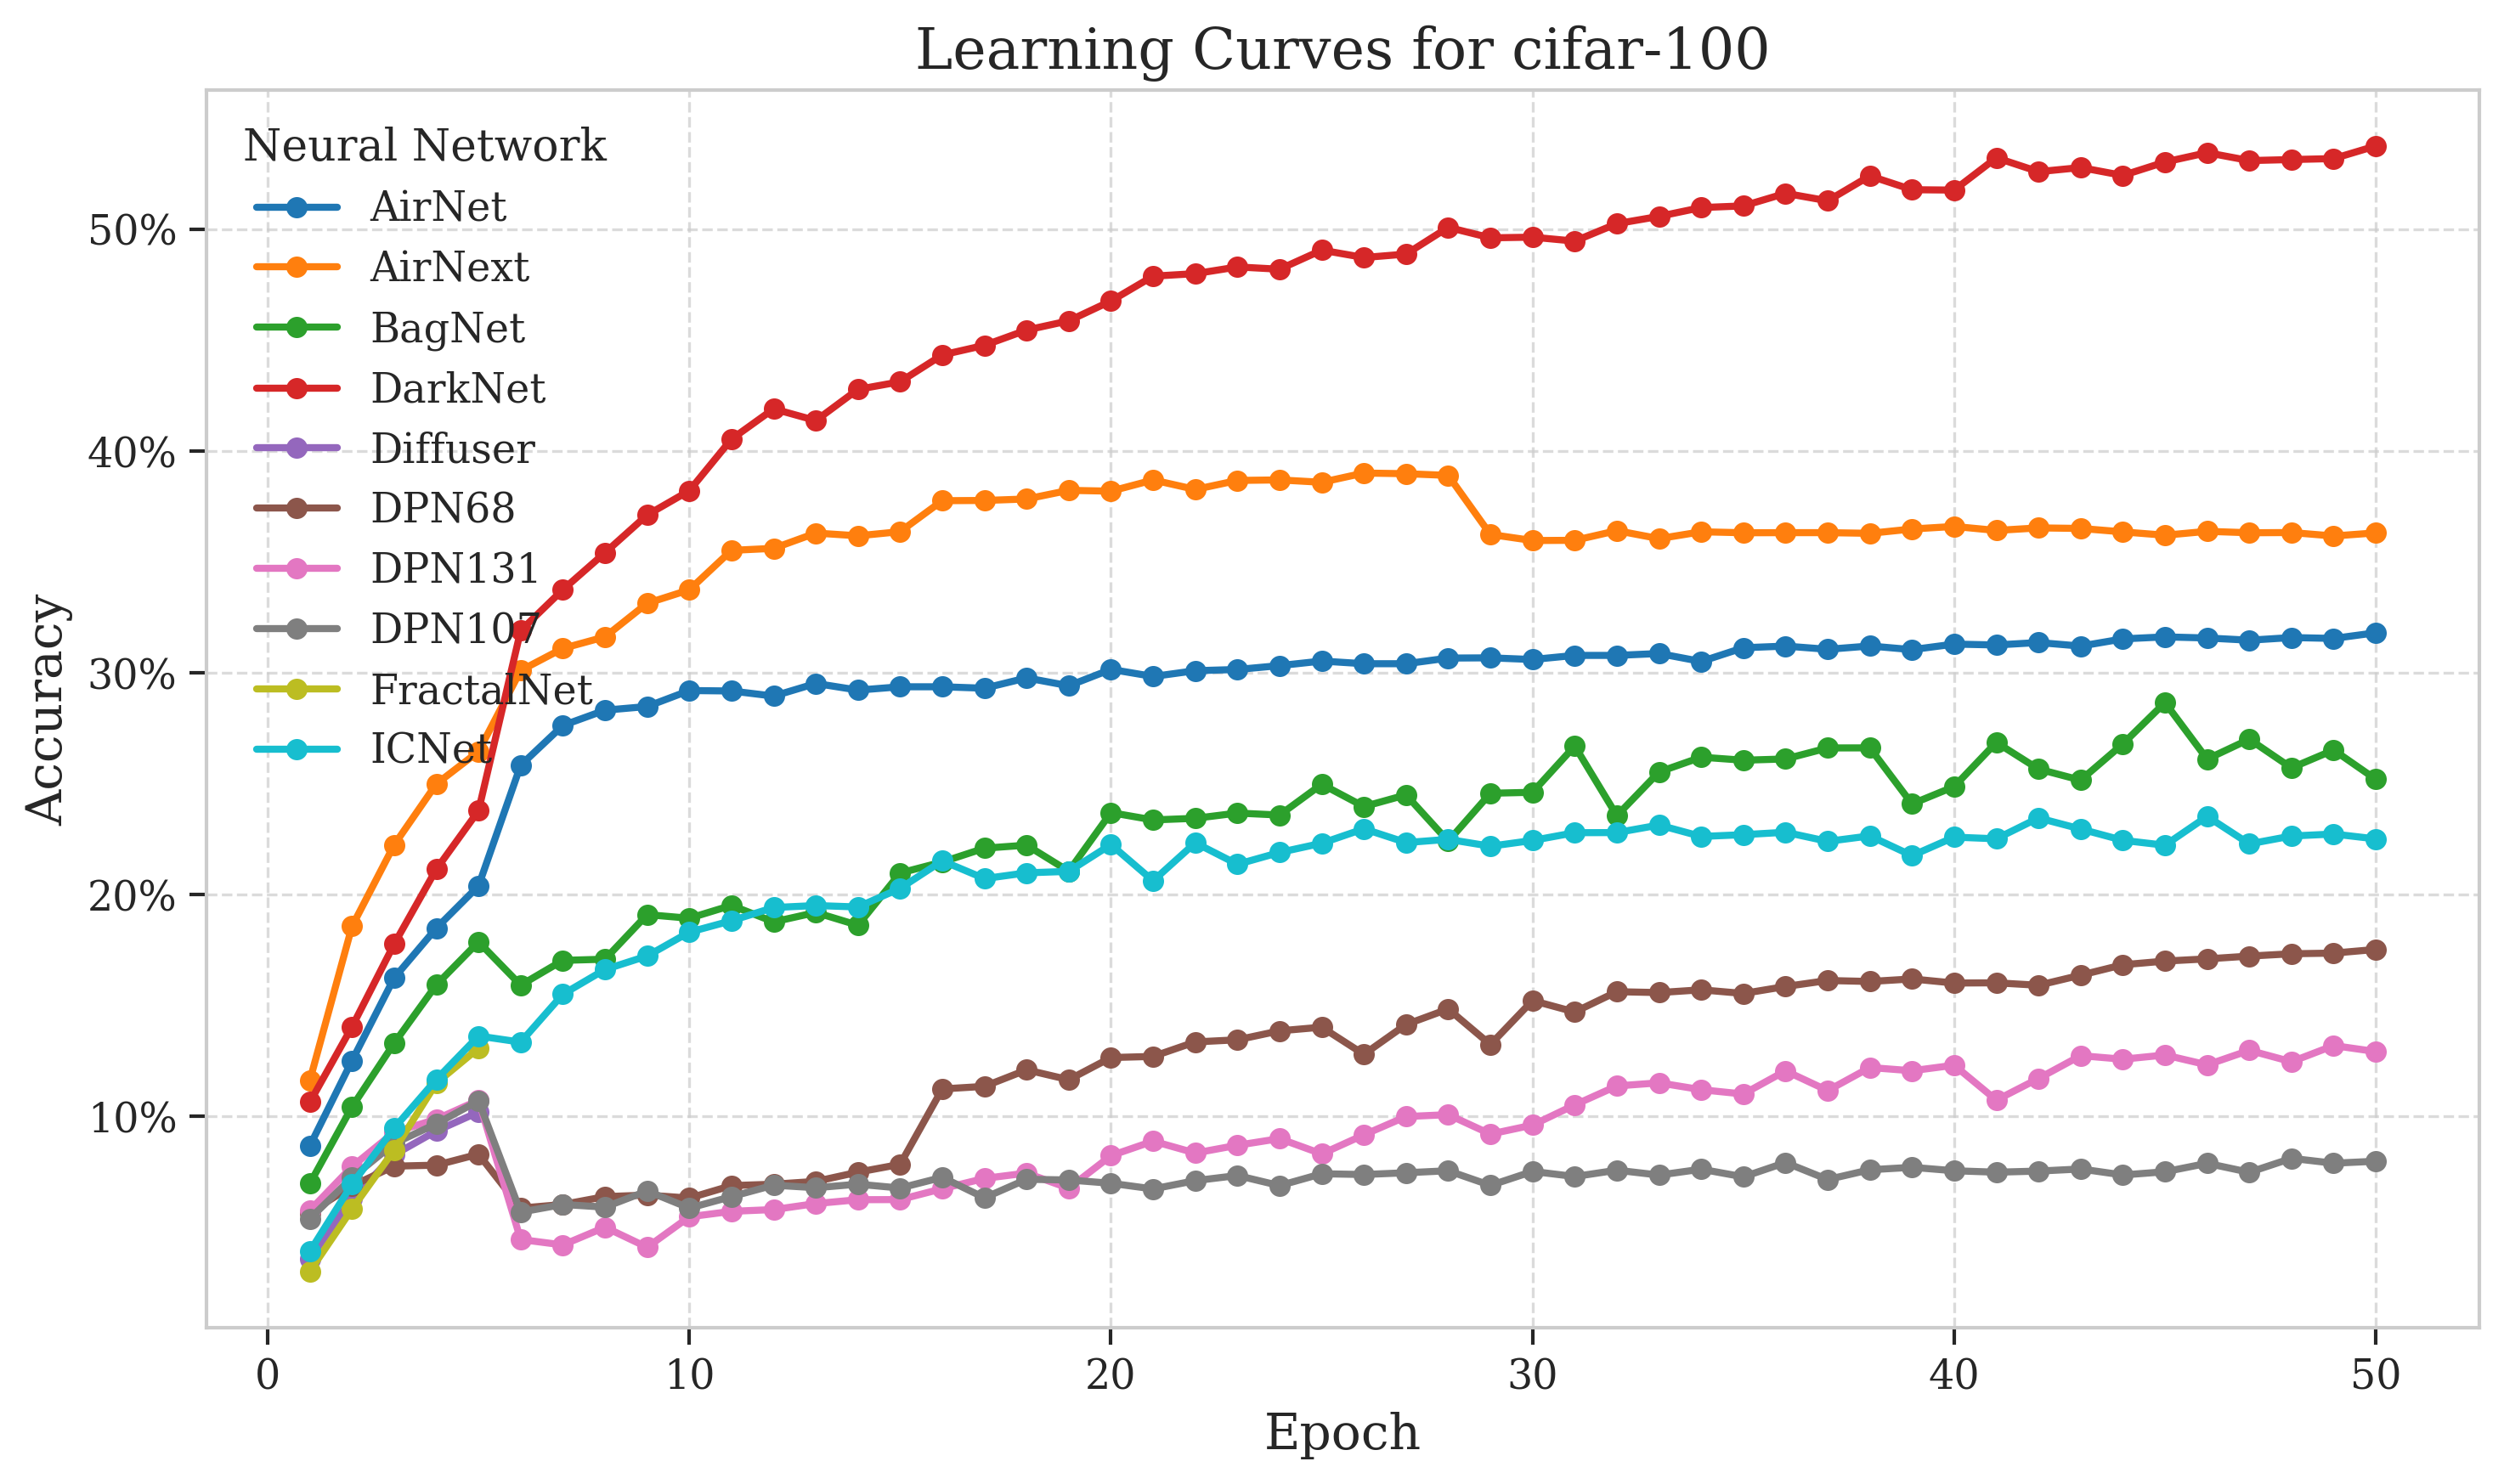

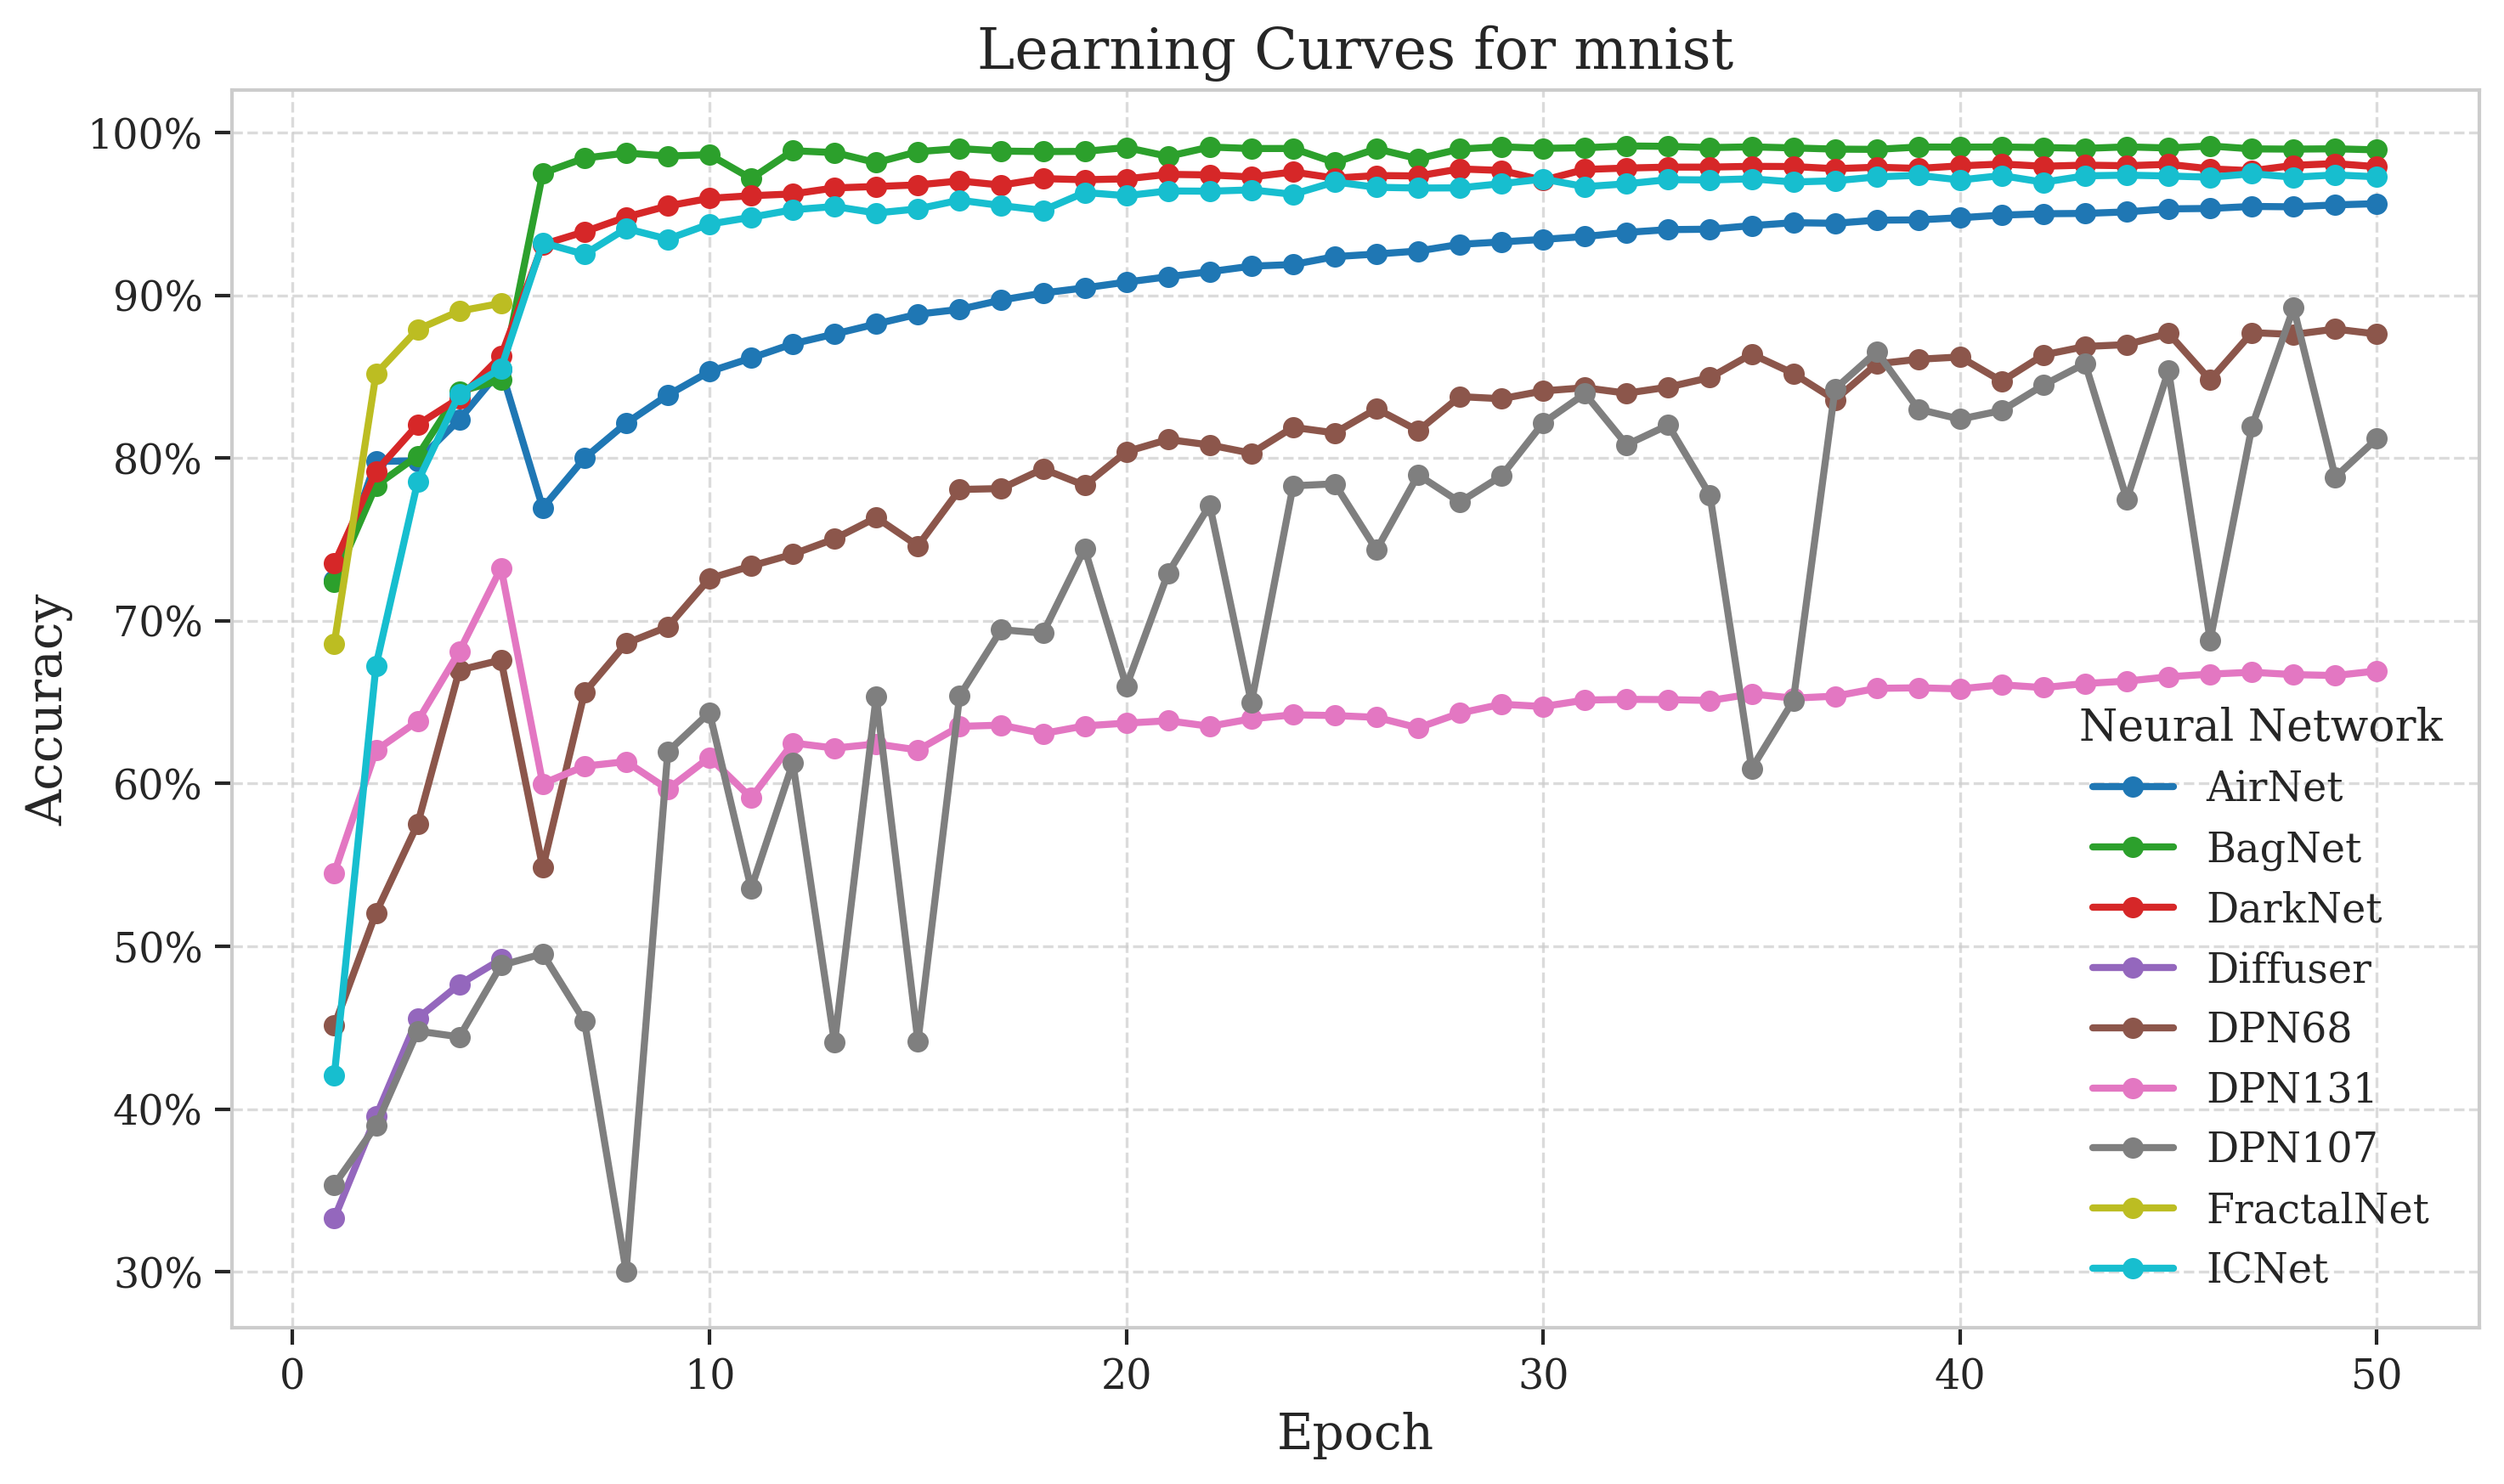

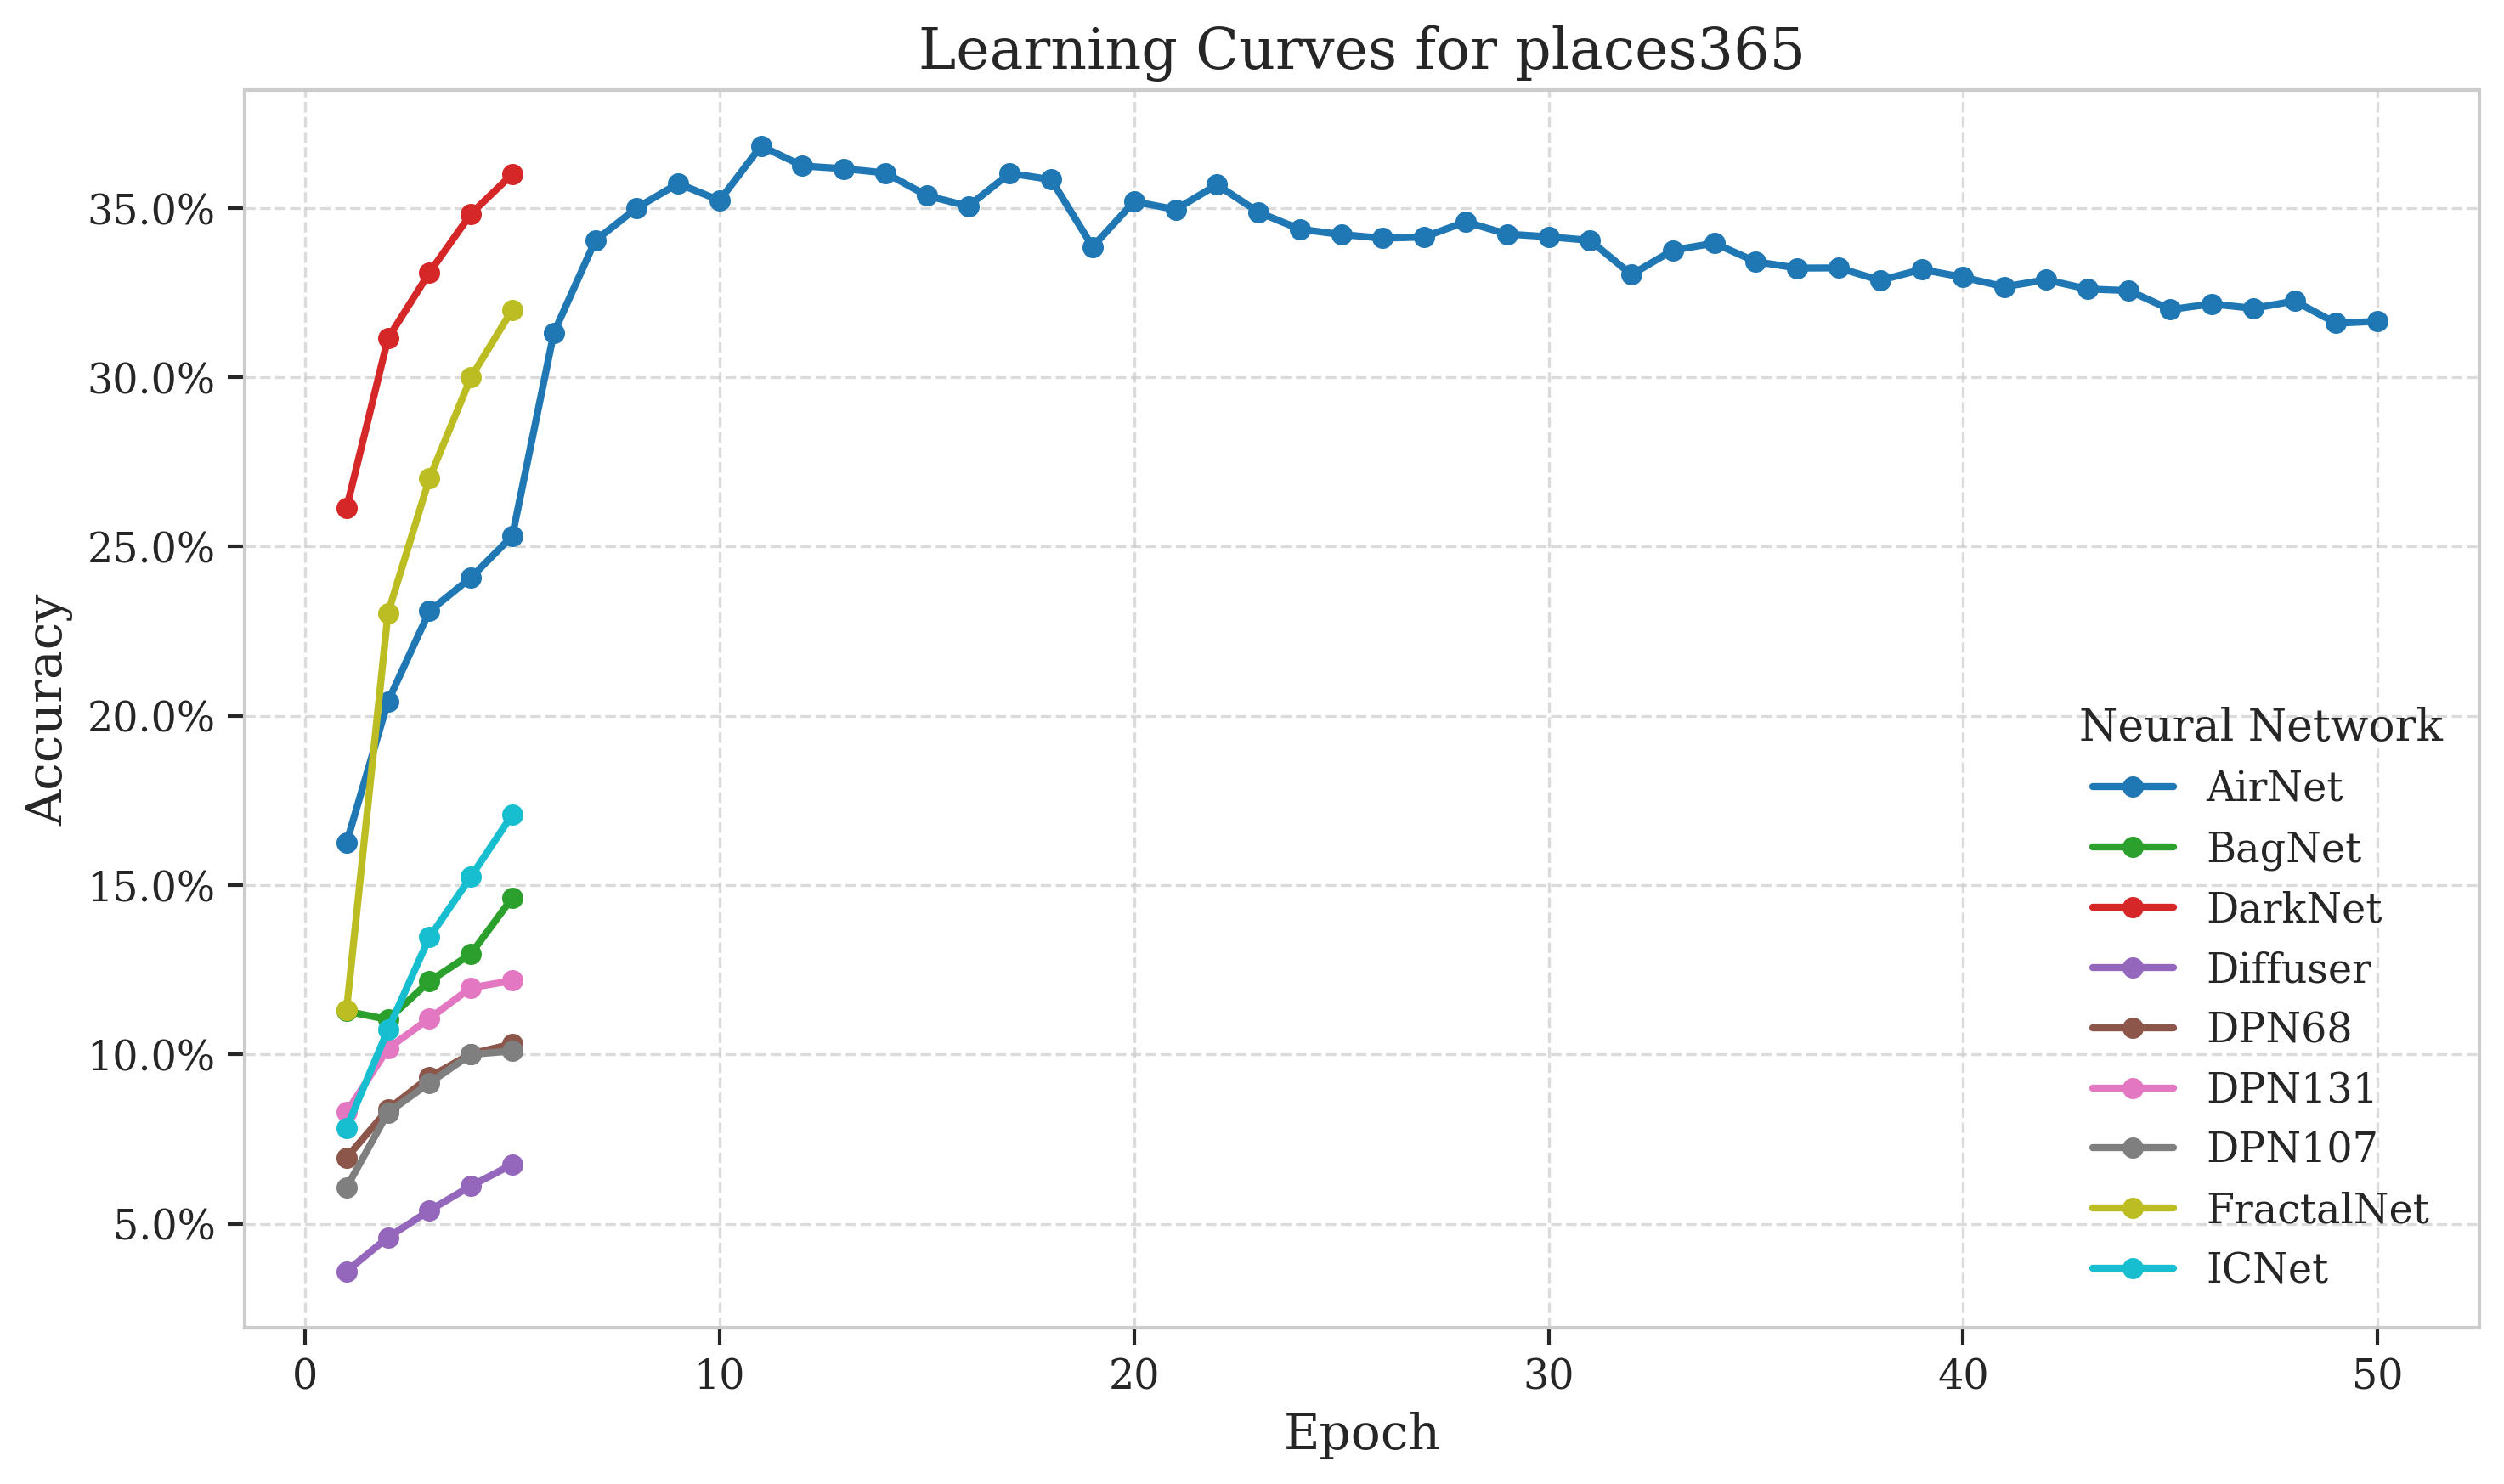

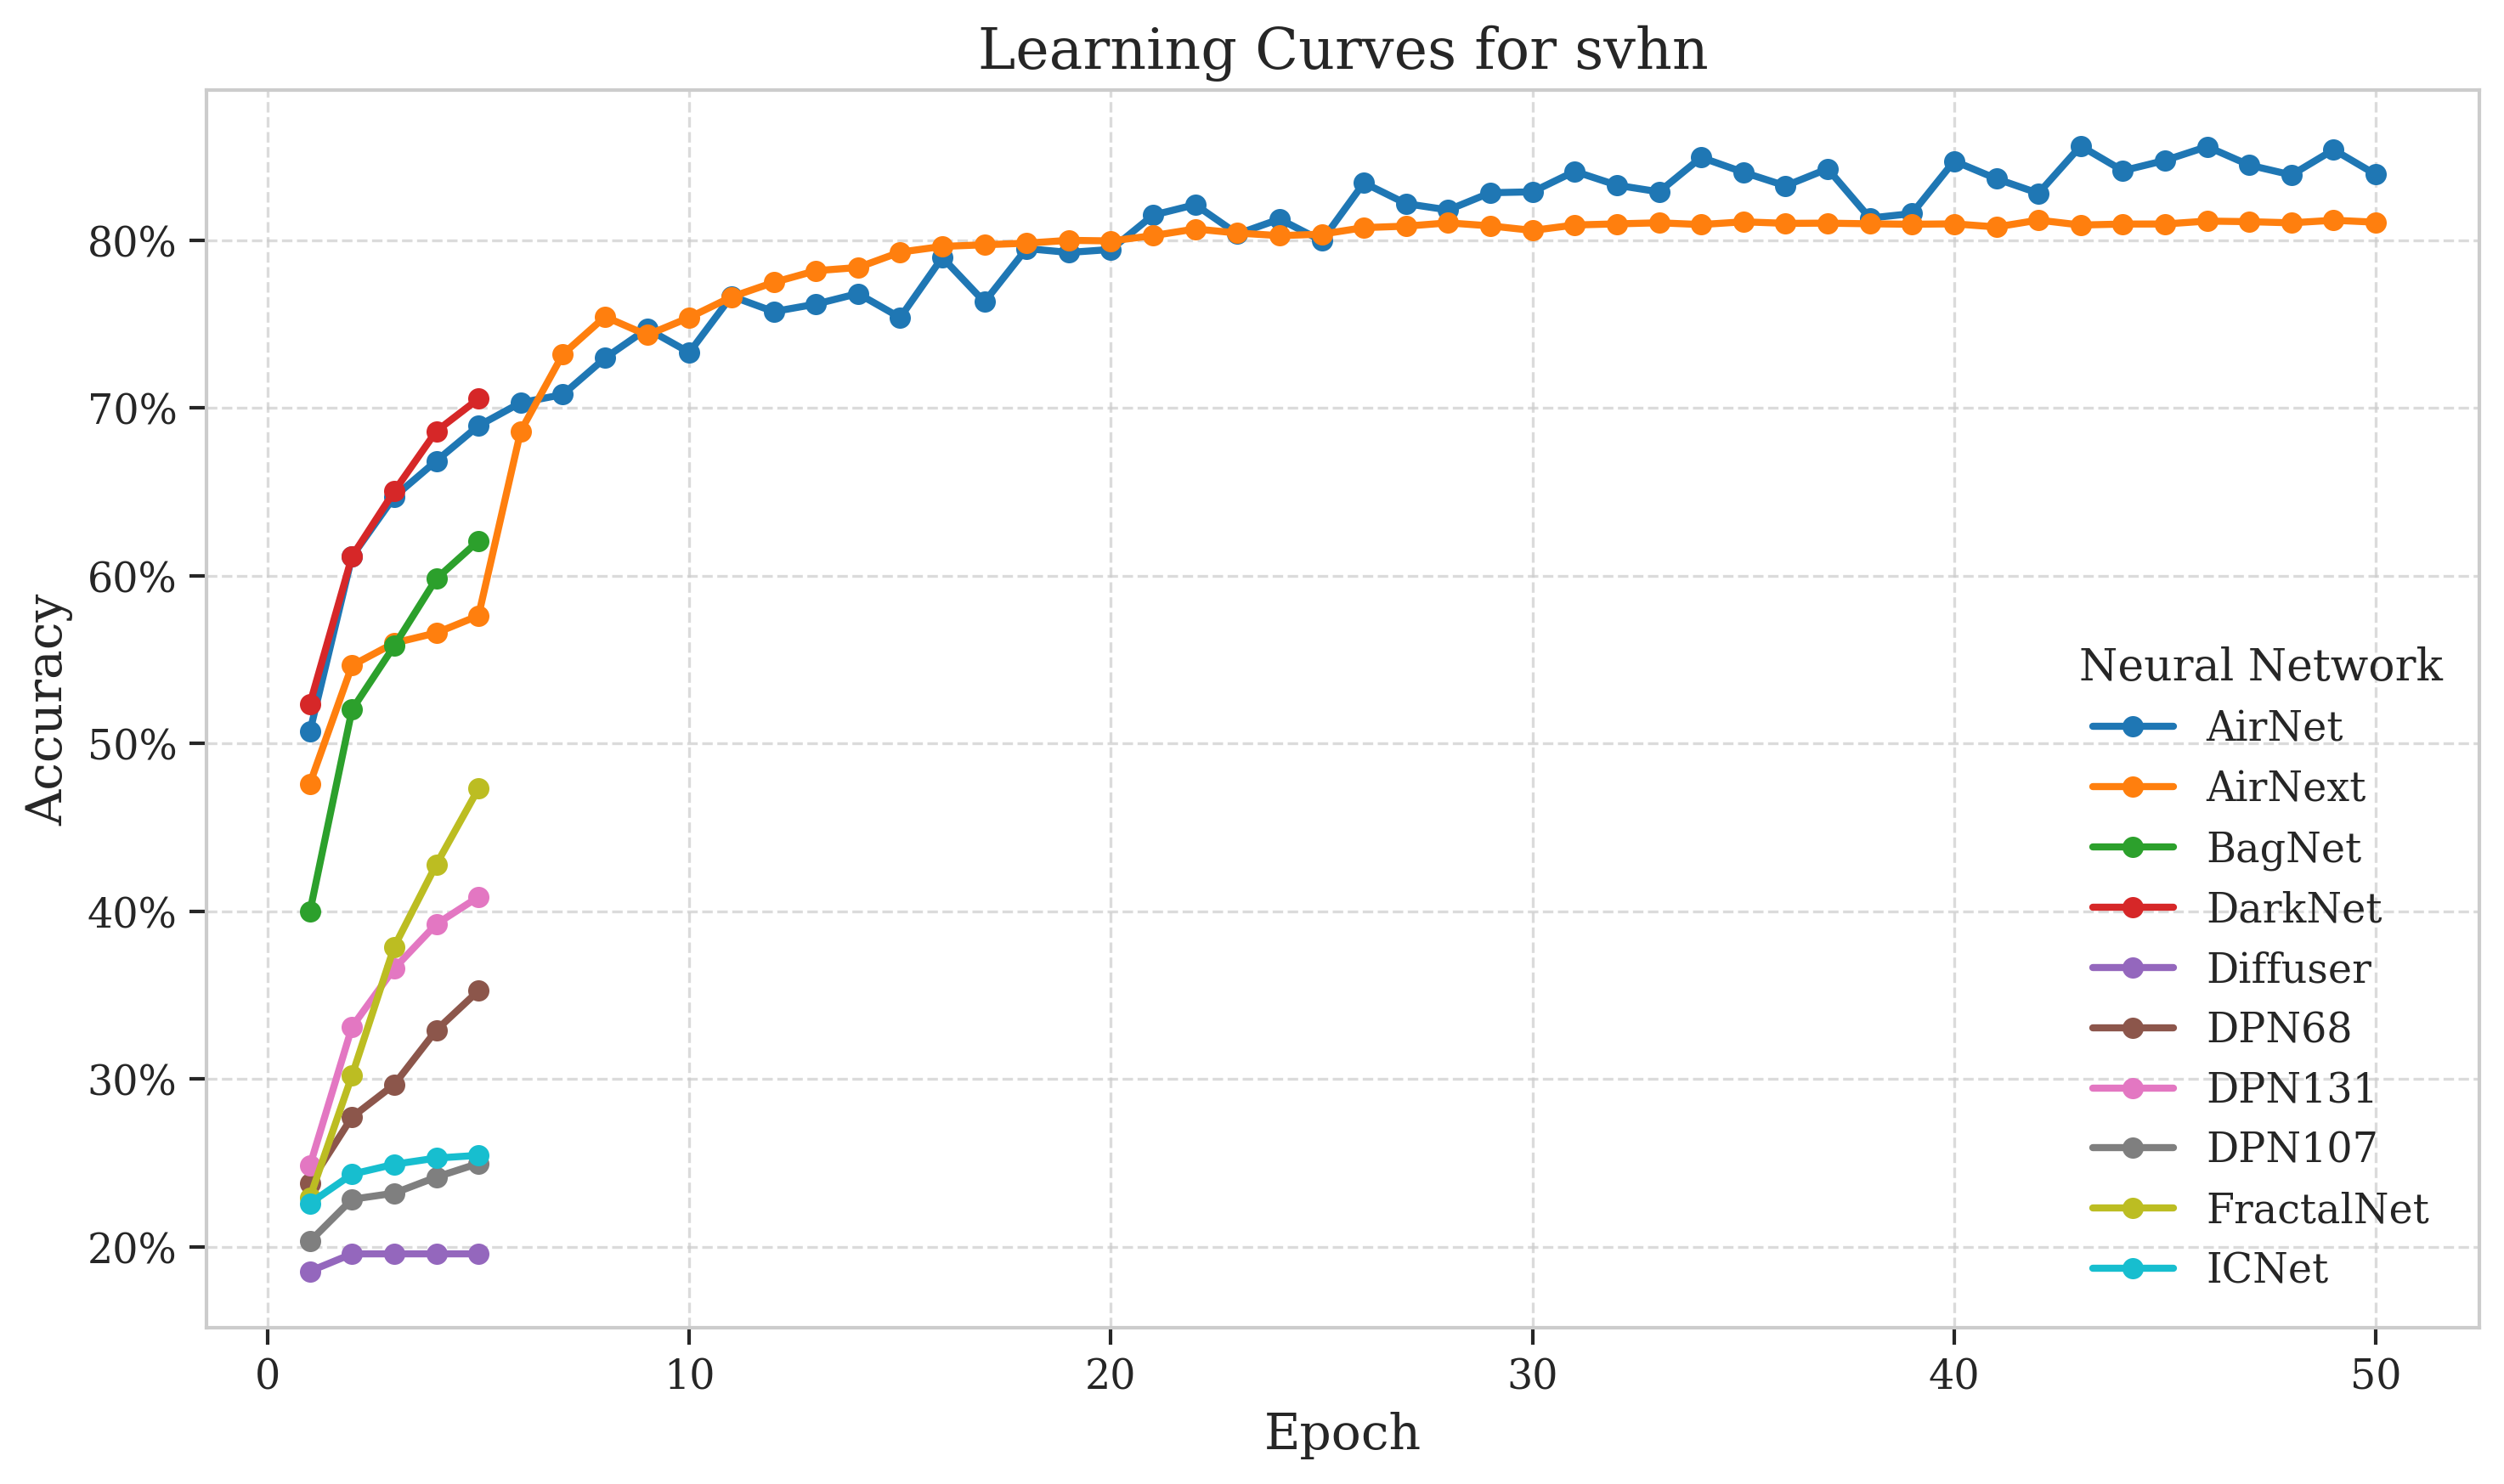

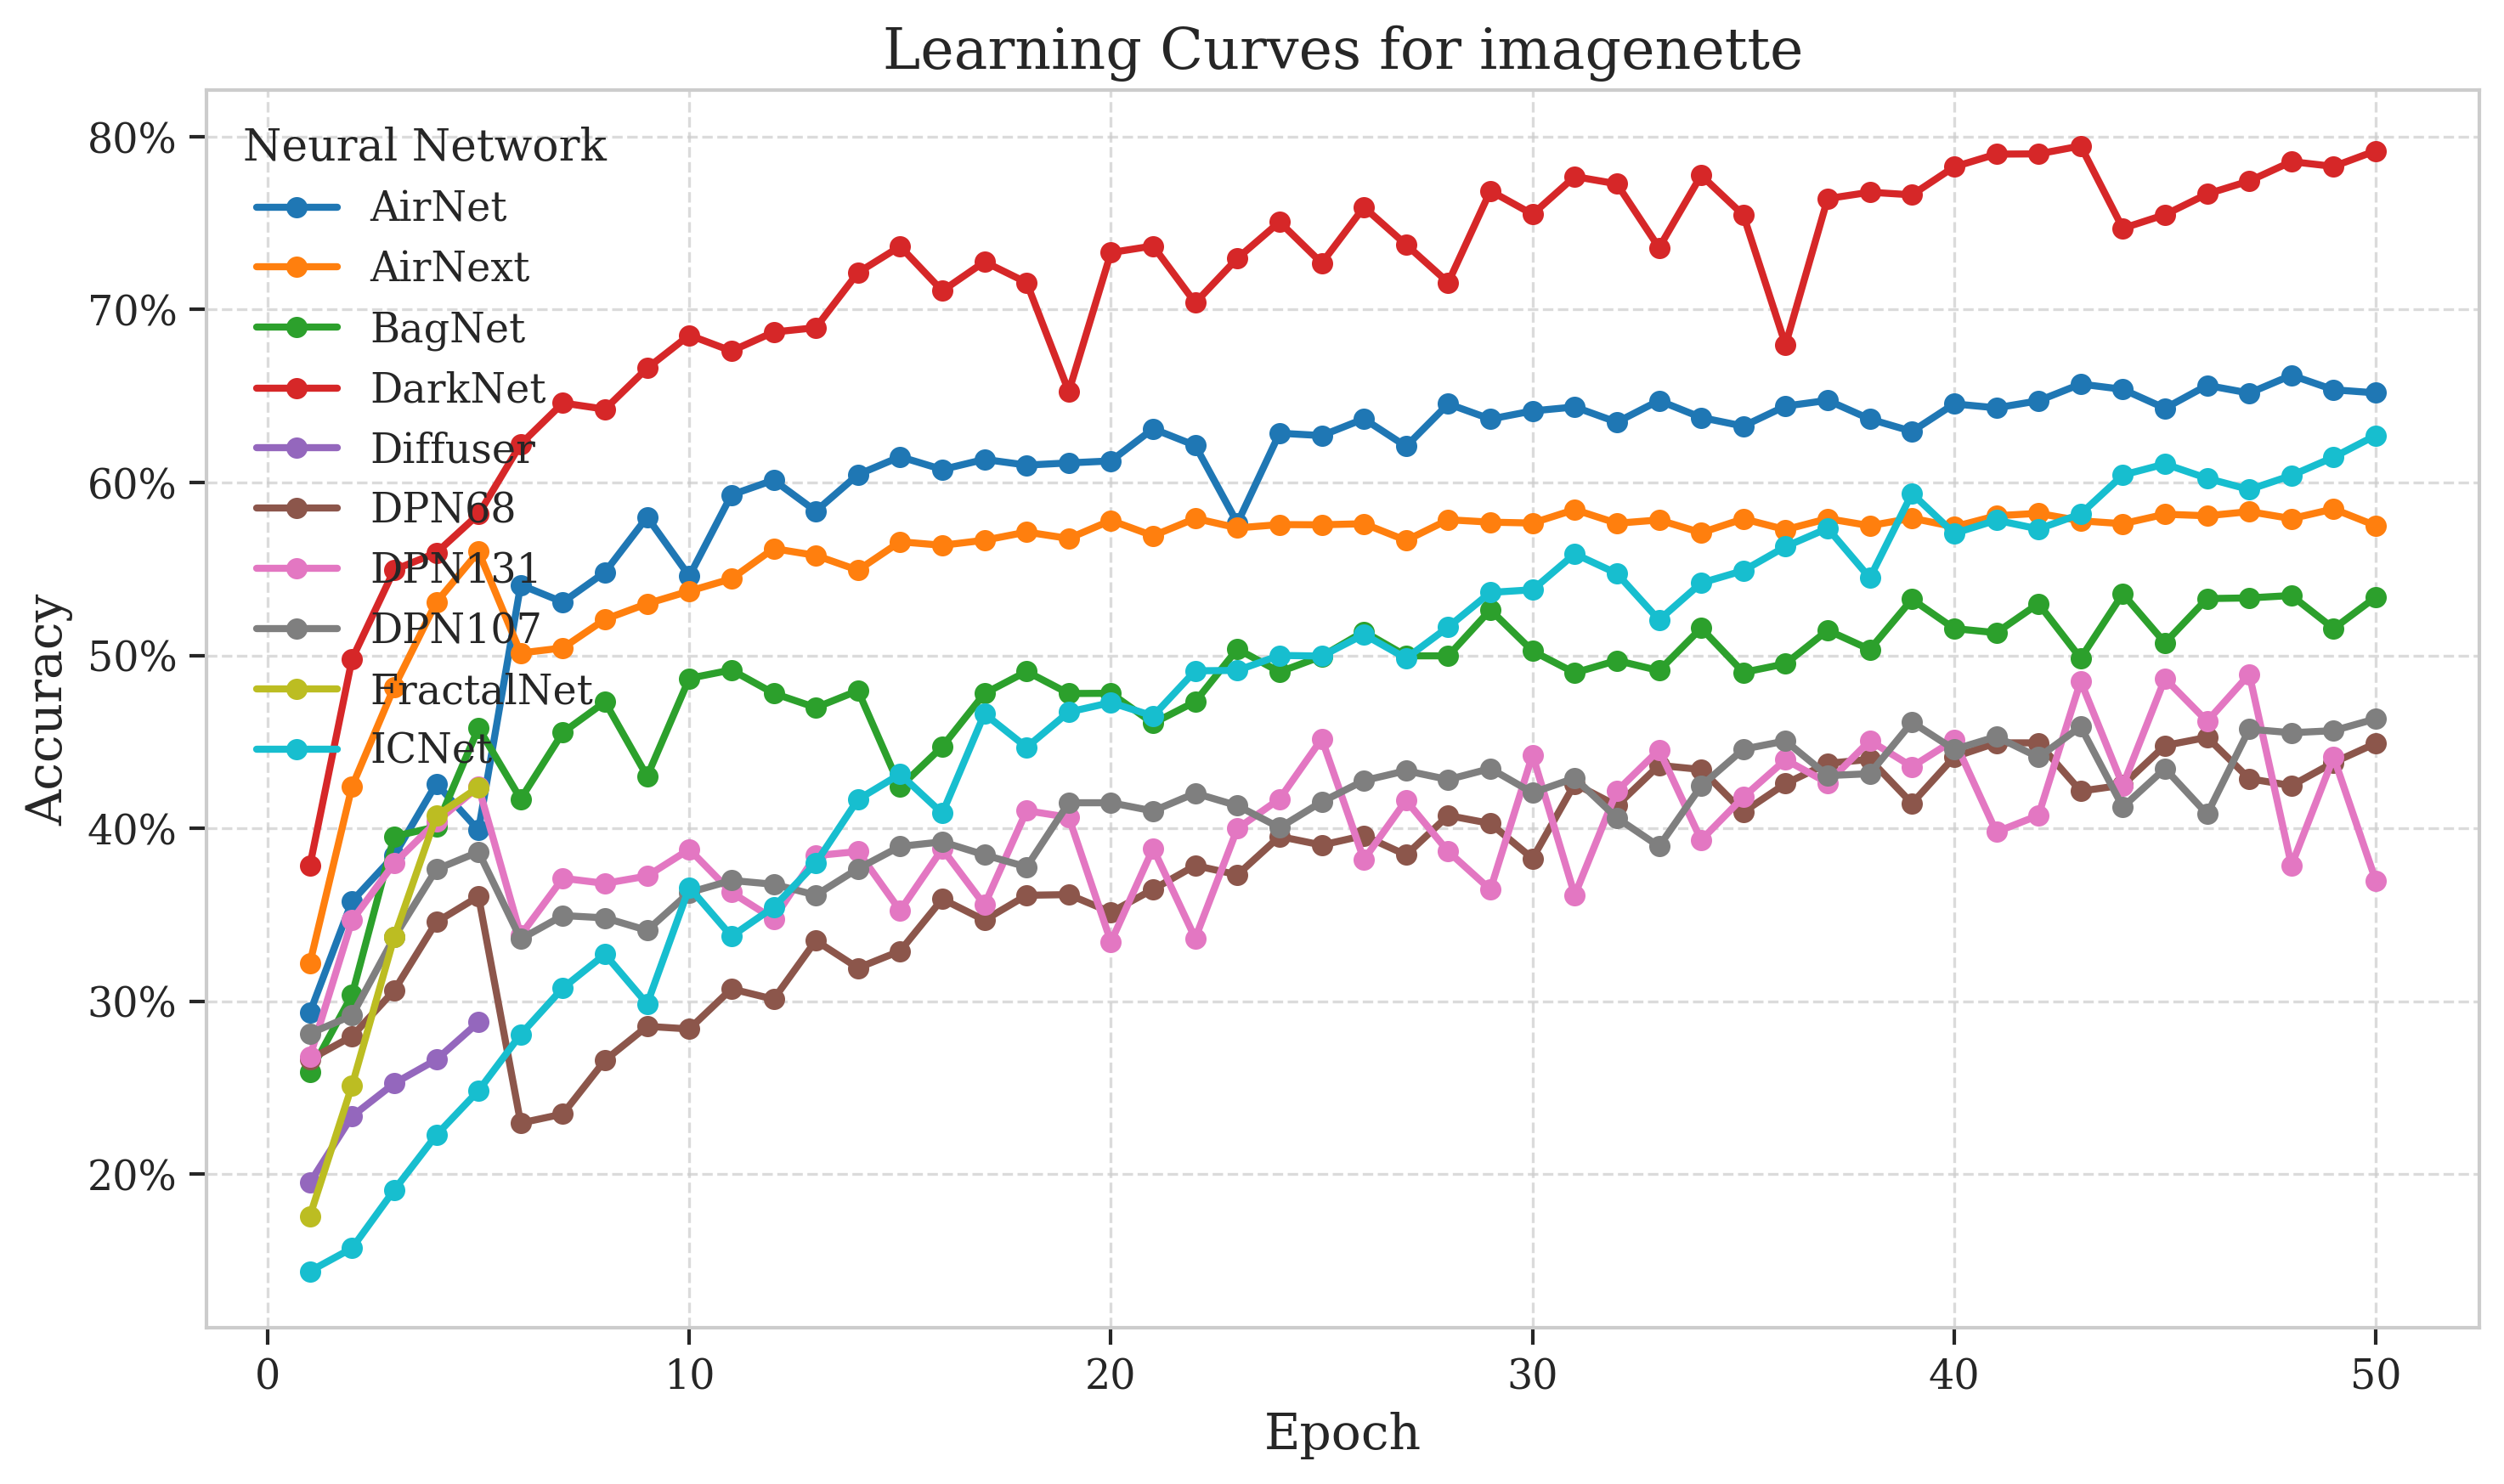

In [7]:
## Visualization 4: Learning Curves

def create_learning_curves():
    print("Creating learning curves for each dataset...")
    for dataset in relevant_datasets:
        dataset_data = filtered_df[filtered_df['dataset'] == dataset]
        
        if dataset_data.empty:
            continue
        
        plt.figure(figsize=(10, 6))
        
        for model in relevant_models:
            model_data = dataset_data[dataset_data['nn'] == model]
            
            # Group by epoch and get mean accuracy
            by_epoch = model_data.groupby('epoch')['accuracy'].mean().reset_index()
            
            if not by_epoch.empty:
                plt.plot(
                    by_epoch['epoch'], 
                    by_epoch['accuracy'], 
                    marker='o', 
                    markersize=5,
                    linewidth=2, 
                    label=model,
                    color=model_colors.get(model)
                )
        
        plt.title(f'Learning Curves for {dataset}', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Neural Network')
        ax = plt.gca()
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        plt.tight_layout()
        plt.savefig(png_dir_raw / f'learning_curve_{dataset}.png')
        
        # Display the plot in the notebook
        plt.show()

# Run the function to create and display learning curves for each dataset
create_learning_curves()

Creating convergence speed visualization...


/tmp/ipykernel_295280/1222271588.py:41: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.barplot(


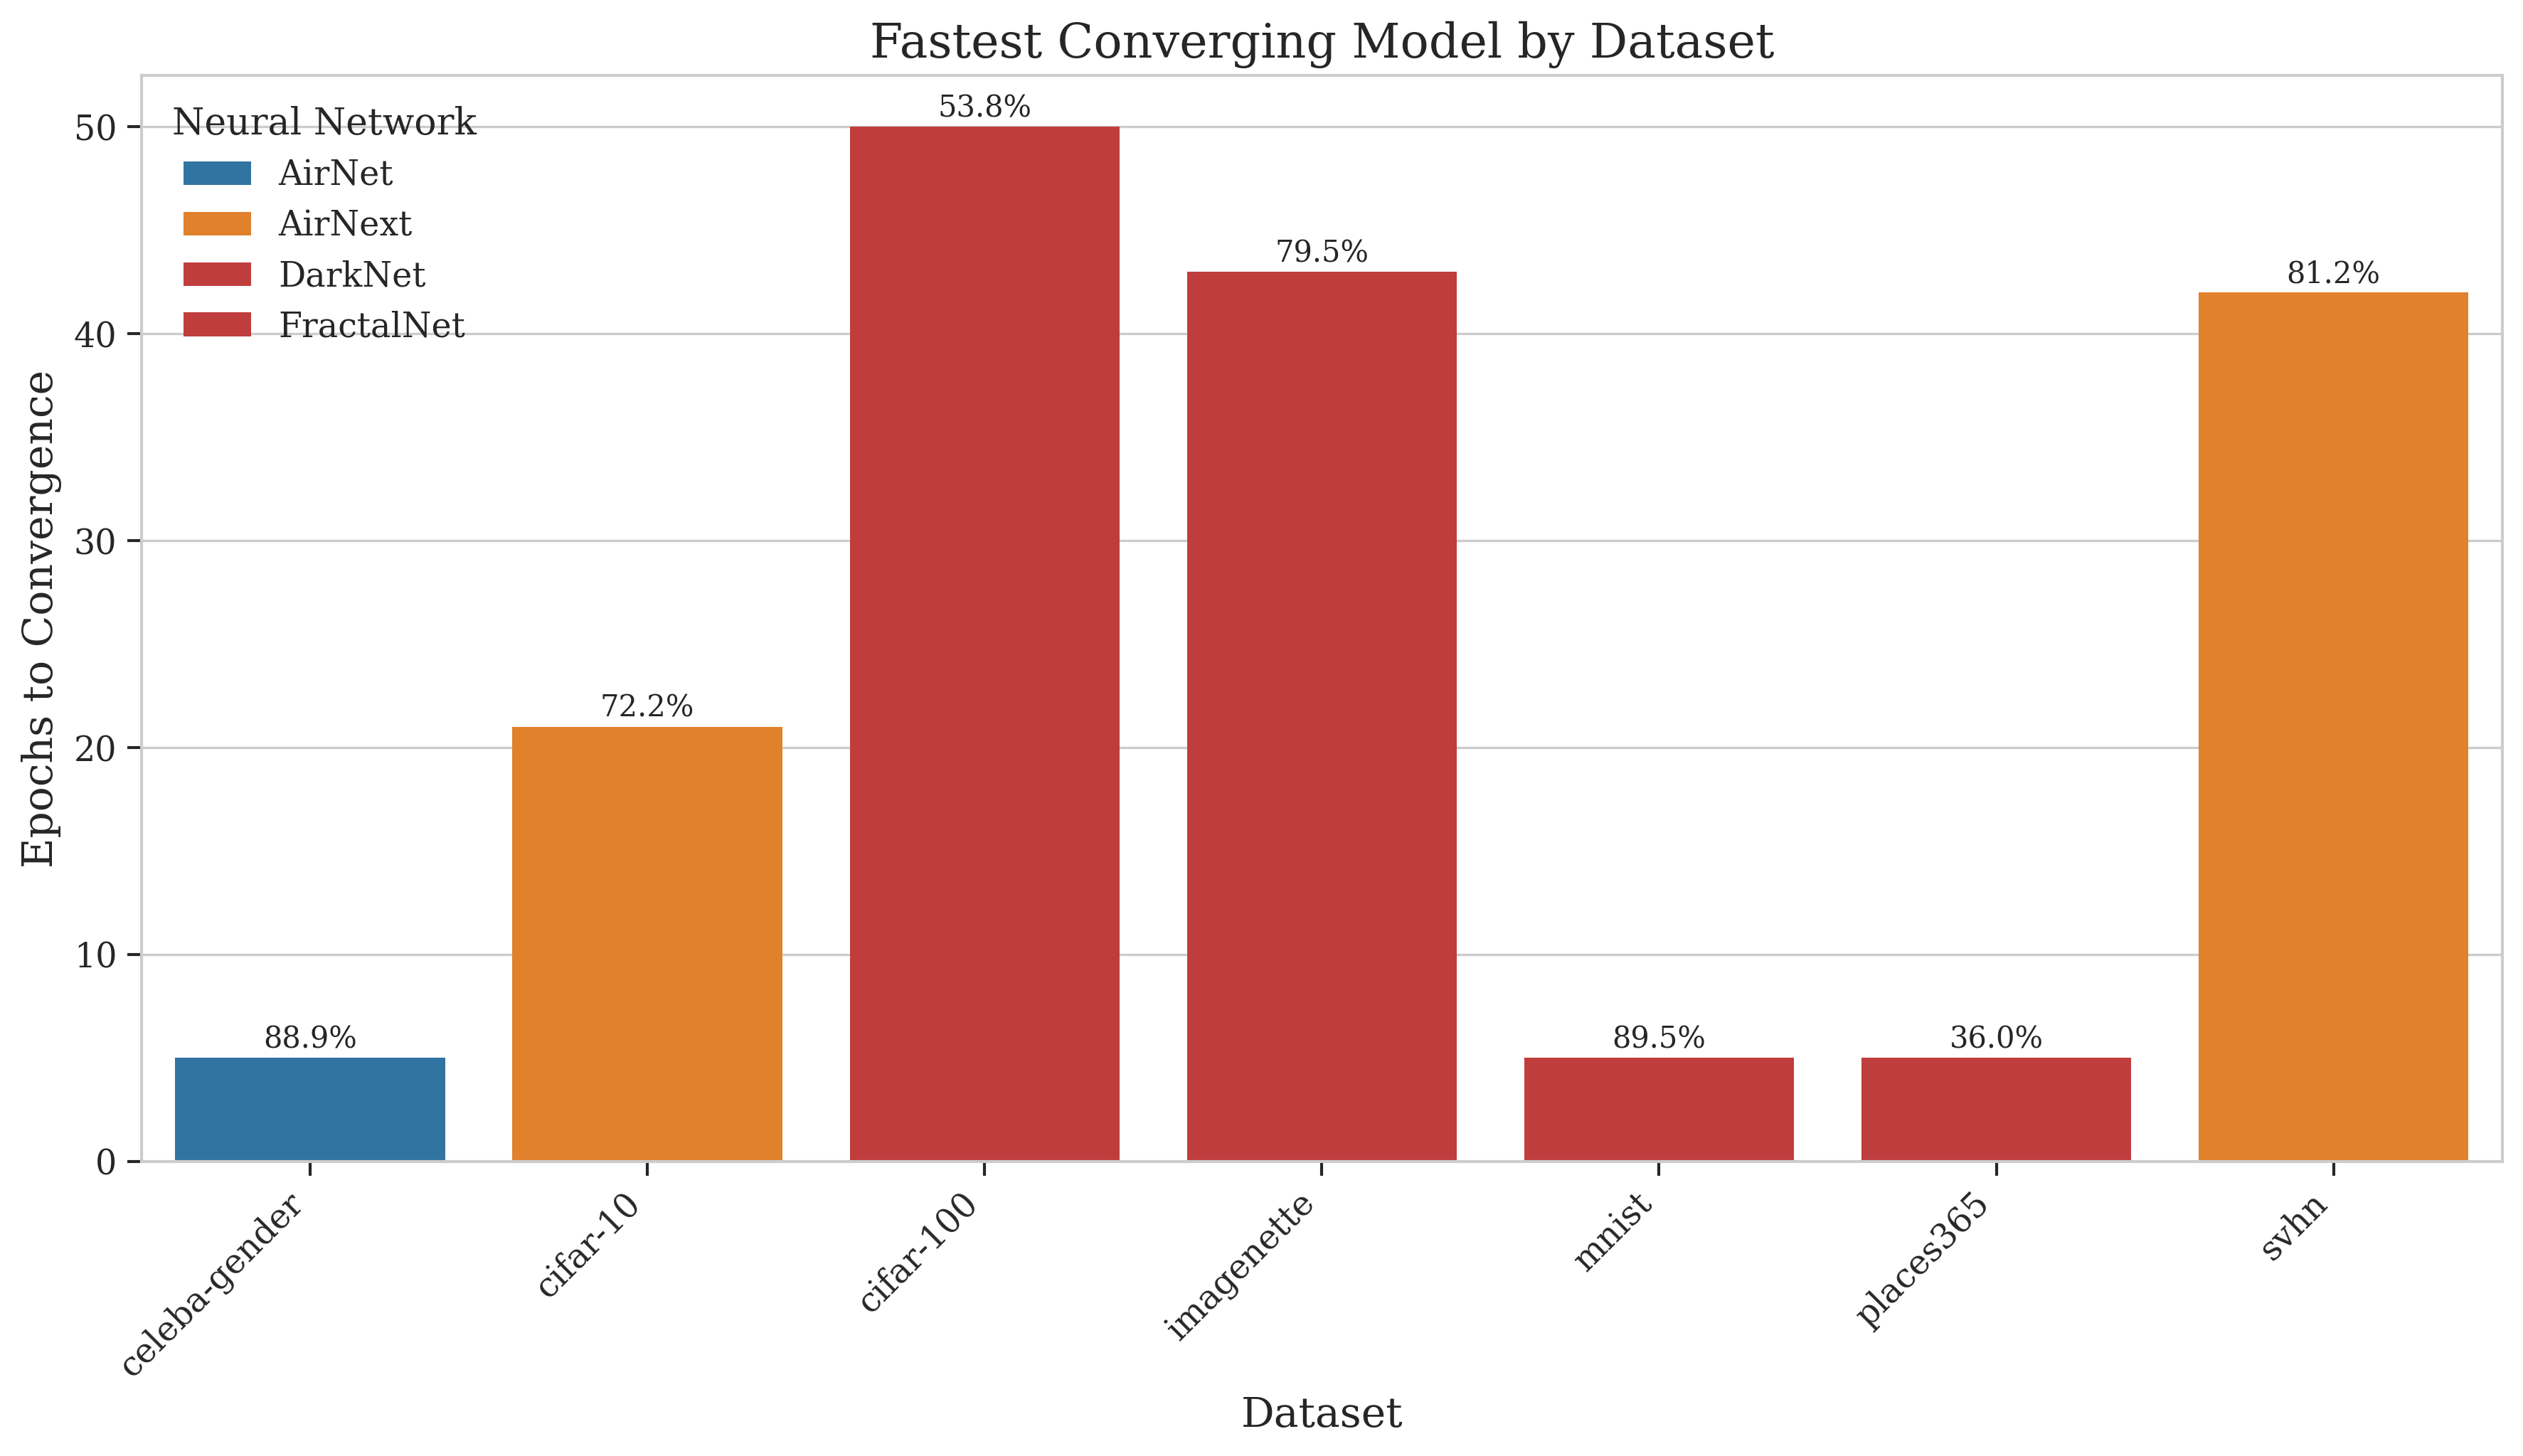

In [8]:
## Visualization 5: Convergence Speed

def create_convergence_visualization():
    print("Creating convergence speed visualization...")
    # Calculate epochs to convergence for each model-dataset combination
    convergence_data = []
    
    for (nn, dataset), group in filtered_df.groupby(['nn', 'dataset']):
        # Group by epoch and get mean accuracy
        by_epoch = group.groupby('epoch')['accuracy'].mean().reset_index()
        
        if not by_epoch.empty:
            max_accuracy = by_epoch['accuracy'].max()
            convergence_epoch = by_epoch.loc[by_epoch['accuracy'].idxmax(), 'epoch']
            
            convergence_data.append({
                'nn': nn,
                'dataset': dataset,
                'max_accuracy': max_accuracy,
                'convergence_epoch': convergence_epoch
            })
    
    convergence_df = pd.DataFrame(convergence_data)
    
    # Find fastest converging model for each dataset that achieves at least 90% of best accuracy
    fastest_models = []
    
    for dataset, dataset_group in convergence_df.groupby('dataset'):
        best_accuracy = dataset_group['max_accuracy'].max()
        threshold = best_accuracy * 0.9
        
        valid_models = dataset_group[dataset_group['max_accuracy'] >= threshold]
        if not valid_models.empty:
            fastest = valid_models.loc[valid_models['convergence_epoch'].idxmin()]
            fastest_models.append(fastest)
    
    fastest_df = pd.DataFrame(fastest_models)
    
    # Create bar chart of convergence epochs
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        x='dataset',
        y='convergence_epoch',
        hue='nn',
        data=fastest_df,
        palette=[model_colors.get(m) for m in fastest_df['nn']]
    )
    
    plt.title('Fastest Converging Model by Dataset', fontsize=16)
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Epochs to Convergence', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add accuracy annotations
    for i, row in enumerate(fastest_df.itertuples()):
        ax.text(
            i, 
            row.convergence_epoch + 0.5, 
            f"{row.max_accuracy:.1%}", 
            ha='center', 
            fontsize=10
        )
    
    plt.legend(title='Neural Network')
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'convergence_speed.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_convergence_visualization()

Creating dataset difficulty visualization...


/tmp/ipykernel_295280/1285569533.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


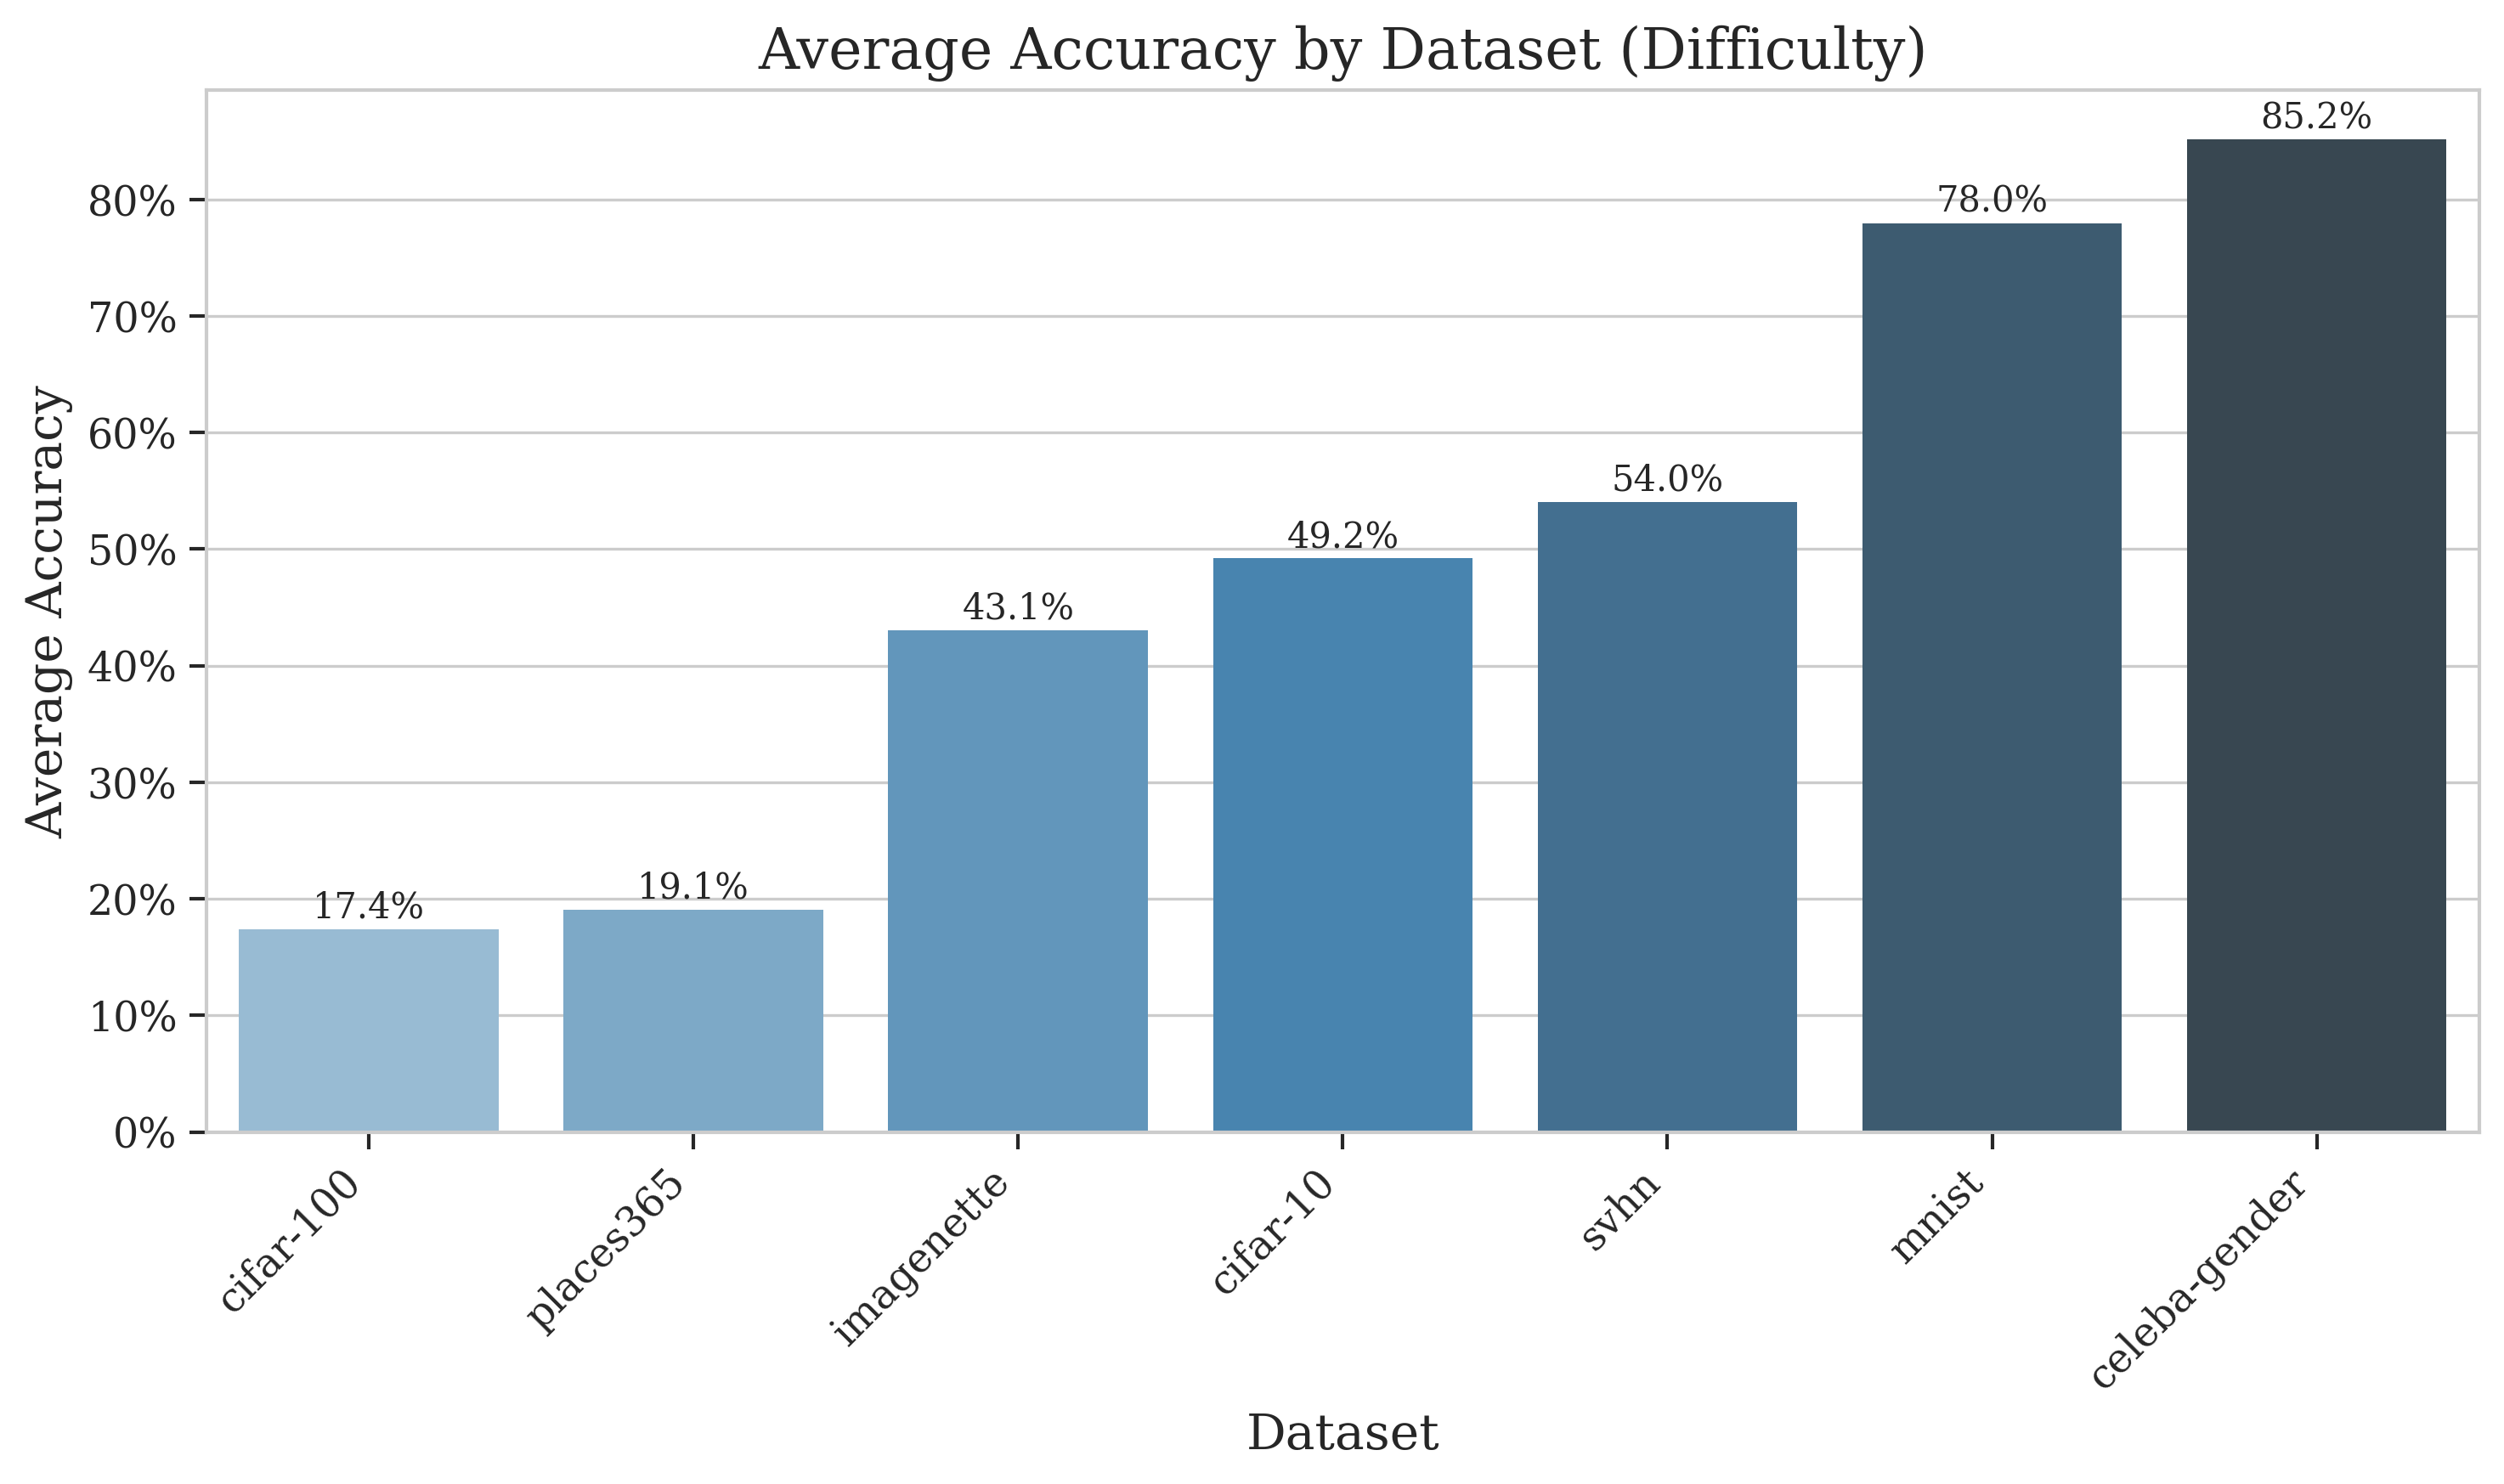

In [9]:
## Visualization 6: Dataset Difficulty

def create_dataset_difficulty_visualization():
    print("Creating dataset difficulty visualization...")
    # Calculate average accuracy across models for each dataset
    dataset_difficulty = filtered_df.groupby('dataset')['accuracy'].mean().sort_values()
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=dataset_difficulty.index, 
        y=dataset_difficulty.values,
        palette='Blues_d'
    )
    
    plt.title('Average Accuracy by Dataset (Difficulty)', fontsize=16)
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Average Accuracy', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage formatting to y-axis
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Add value labels
    for i, v in enumerate(dataset_difficulty.values):
        ax.text(i, v + 0.01, f"{v:.1%}", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'dataset_difficulty.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_dataset_difficulty_visualization()


Creating best model visualization...


/tmp/ipykernel_295280/2765698516.py:8: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  ax = sns.barplot(


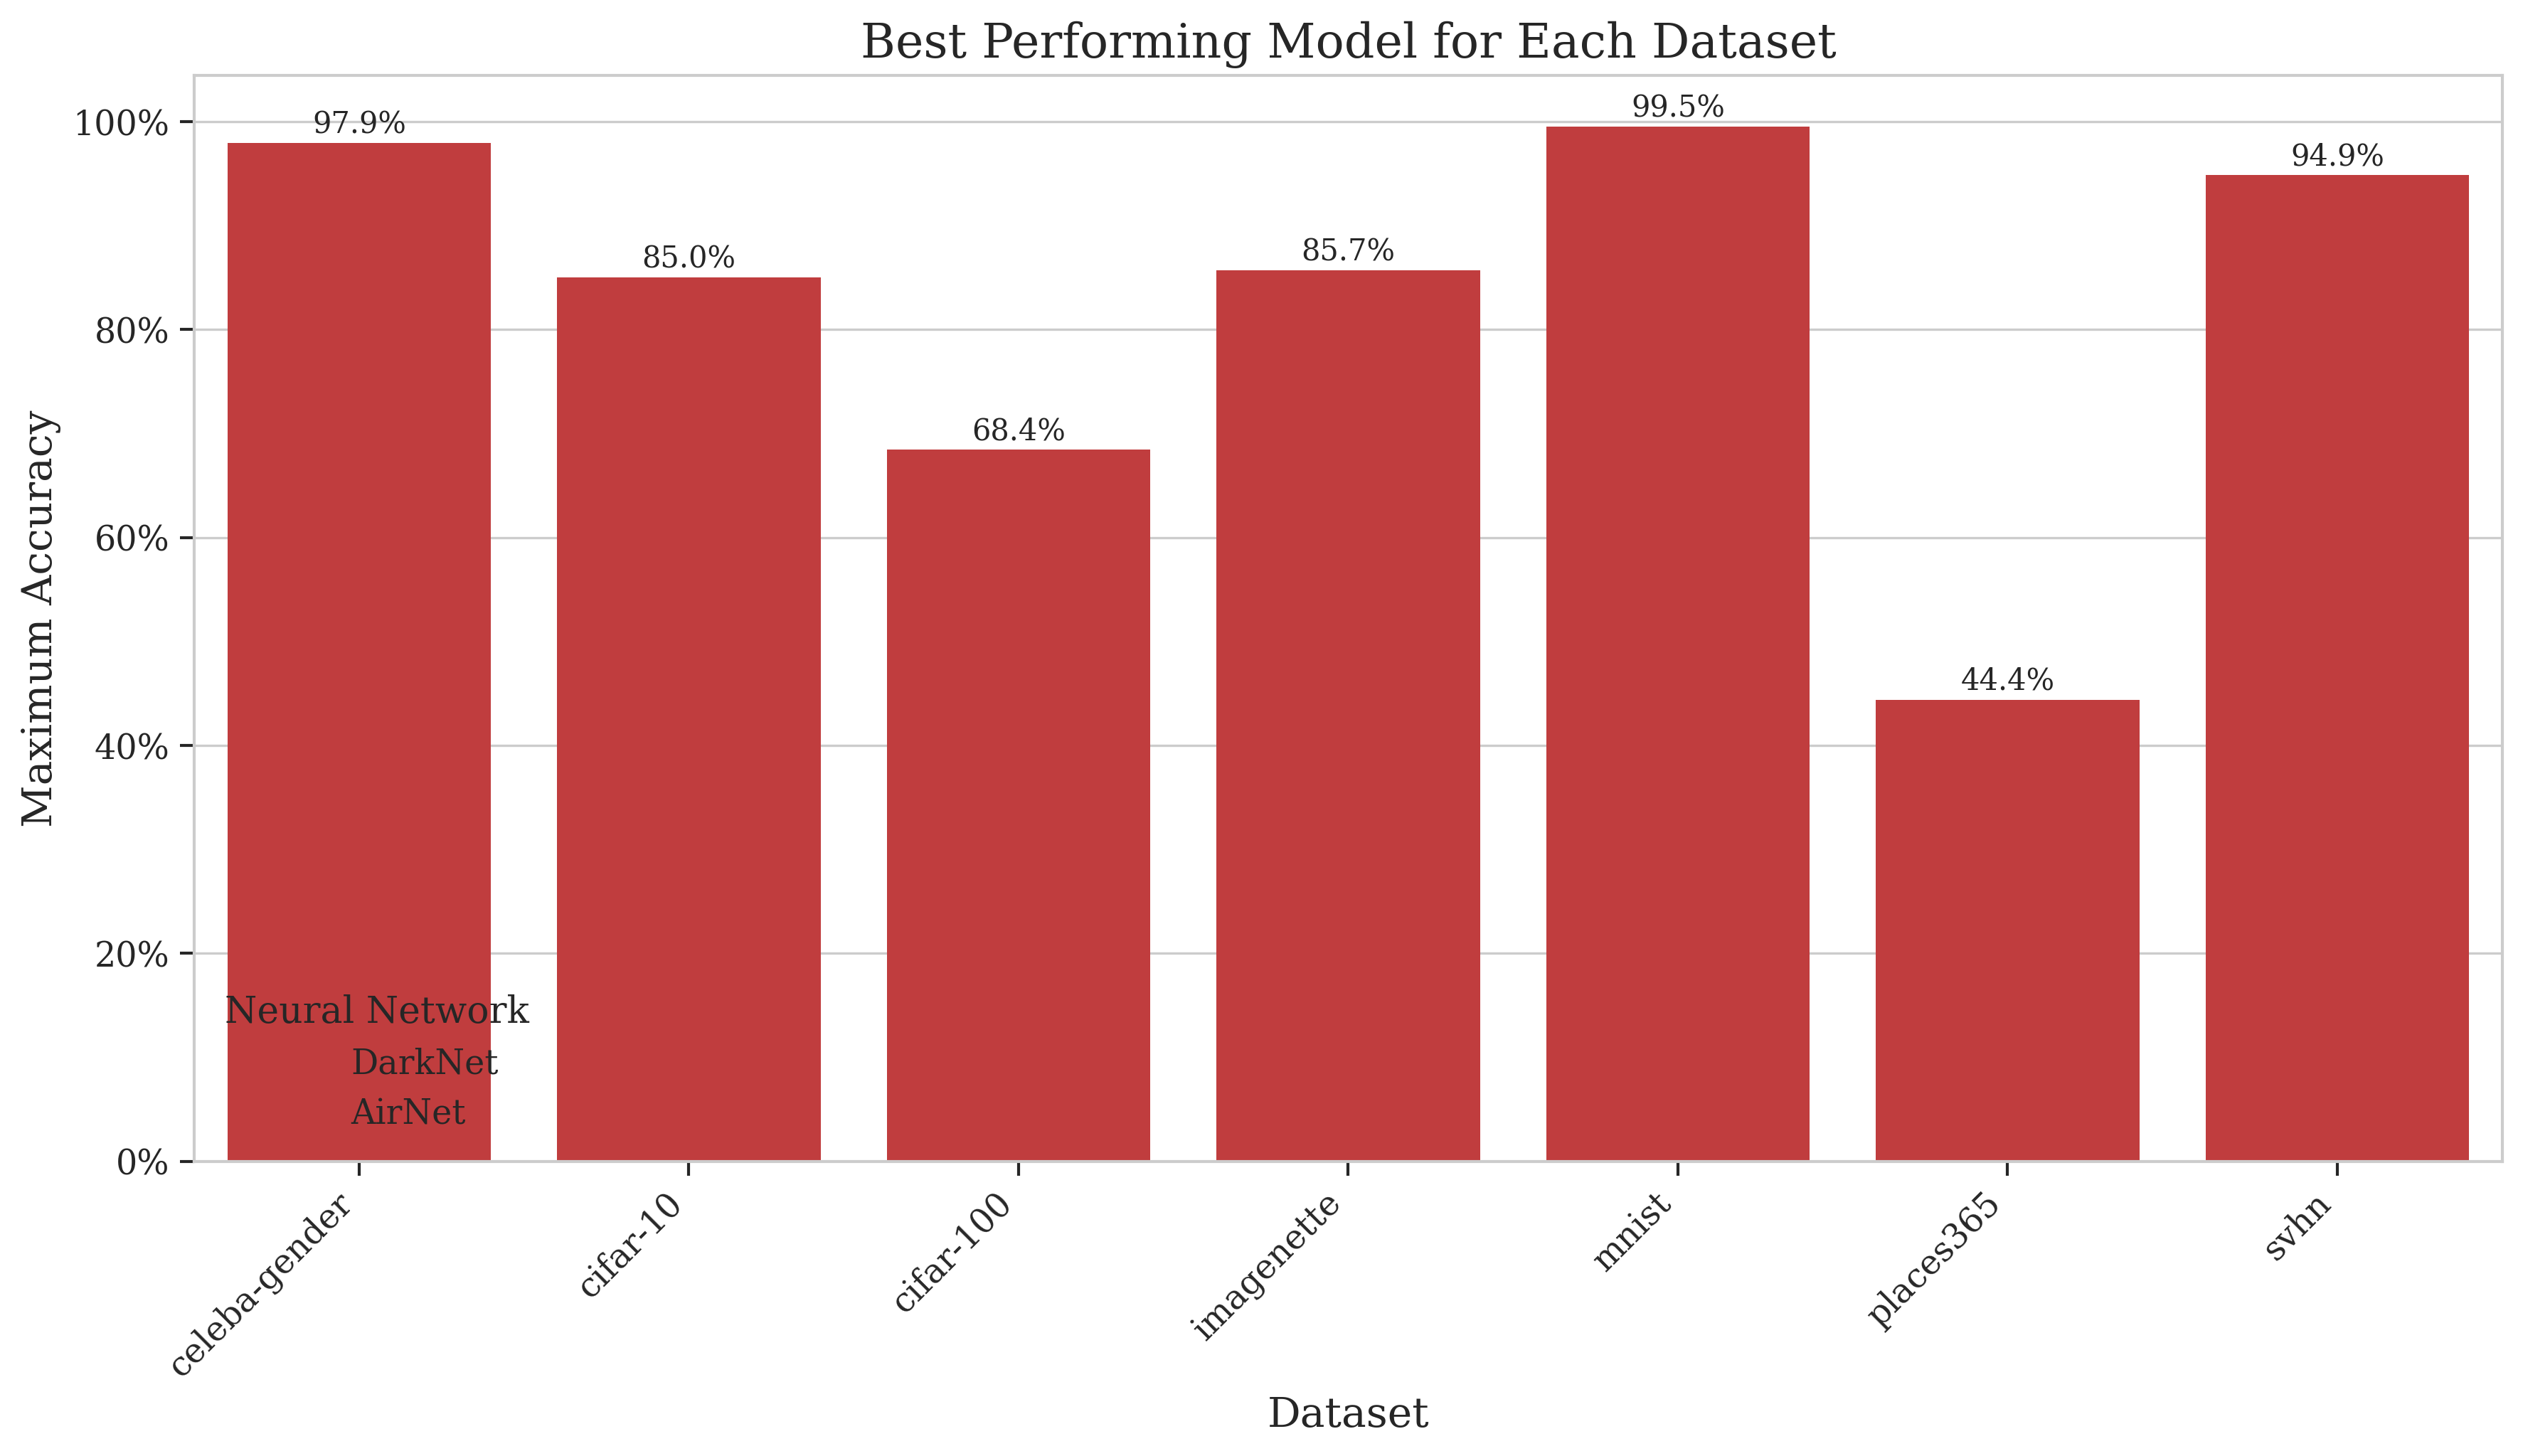

In [10]:
## Visualization 7: Best Model for Each Dataset

def create_best_model_visualization():
    print("Creating best model visualization...")
    best_models = filtered_df.loc[filtered_df.groupby('dataset')['accuracy'].idxmax()]
    
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        x='dataset', 
        y='accuracy', 
        hue='nn', 
        data=best_models,
        palette=[model_colors.get(m) for m in best_models['nn']]
    )
    
    plt.title('Best Performing Model for Each Dataset', fontsize=16)
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Maximum Accuracy', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage formatting to y-axis
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Add value labels
    for i, row in enumerate(best_models.itertuples()):
        ax.text(i, row.accuracy + 0.01, f"{row.accuracy:.1%}", ha='center', fontsize=10)
    
    plt.legend(title='Neural Network')
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'best_models.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_best_model_visualization()


Creating all models performance visualization...


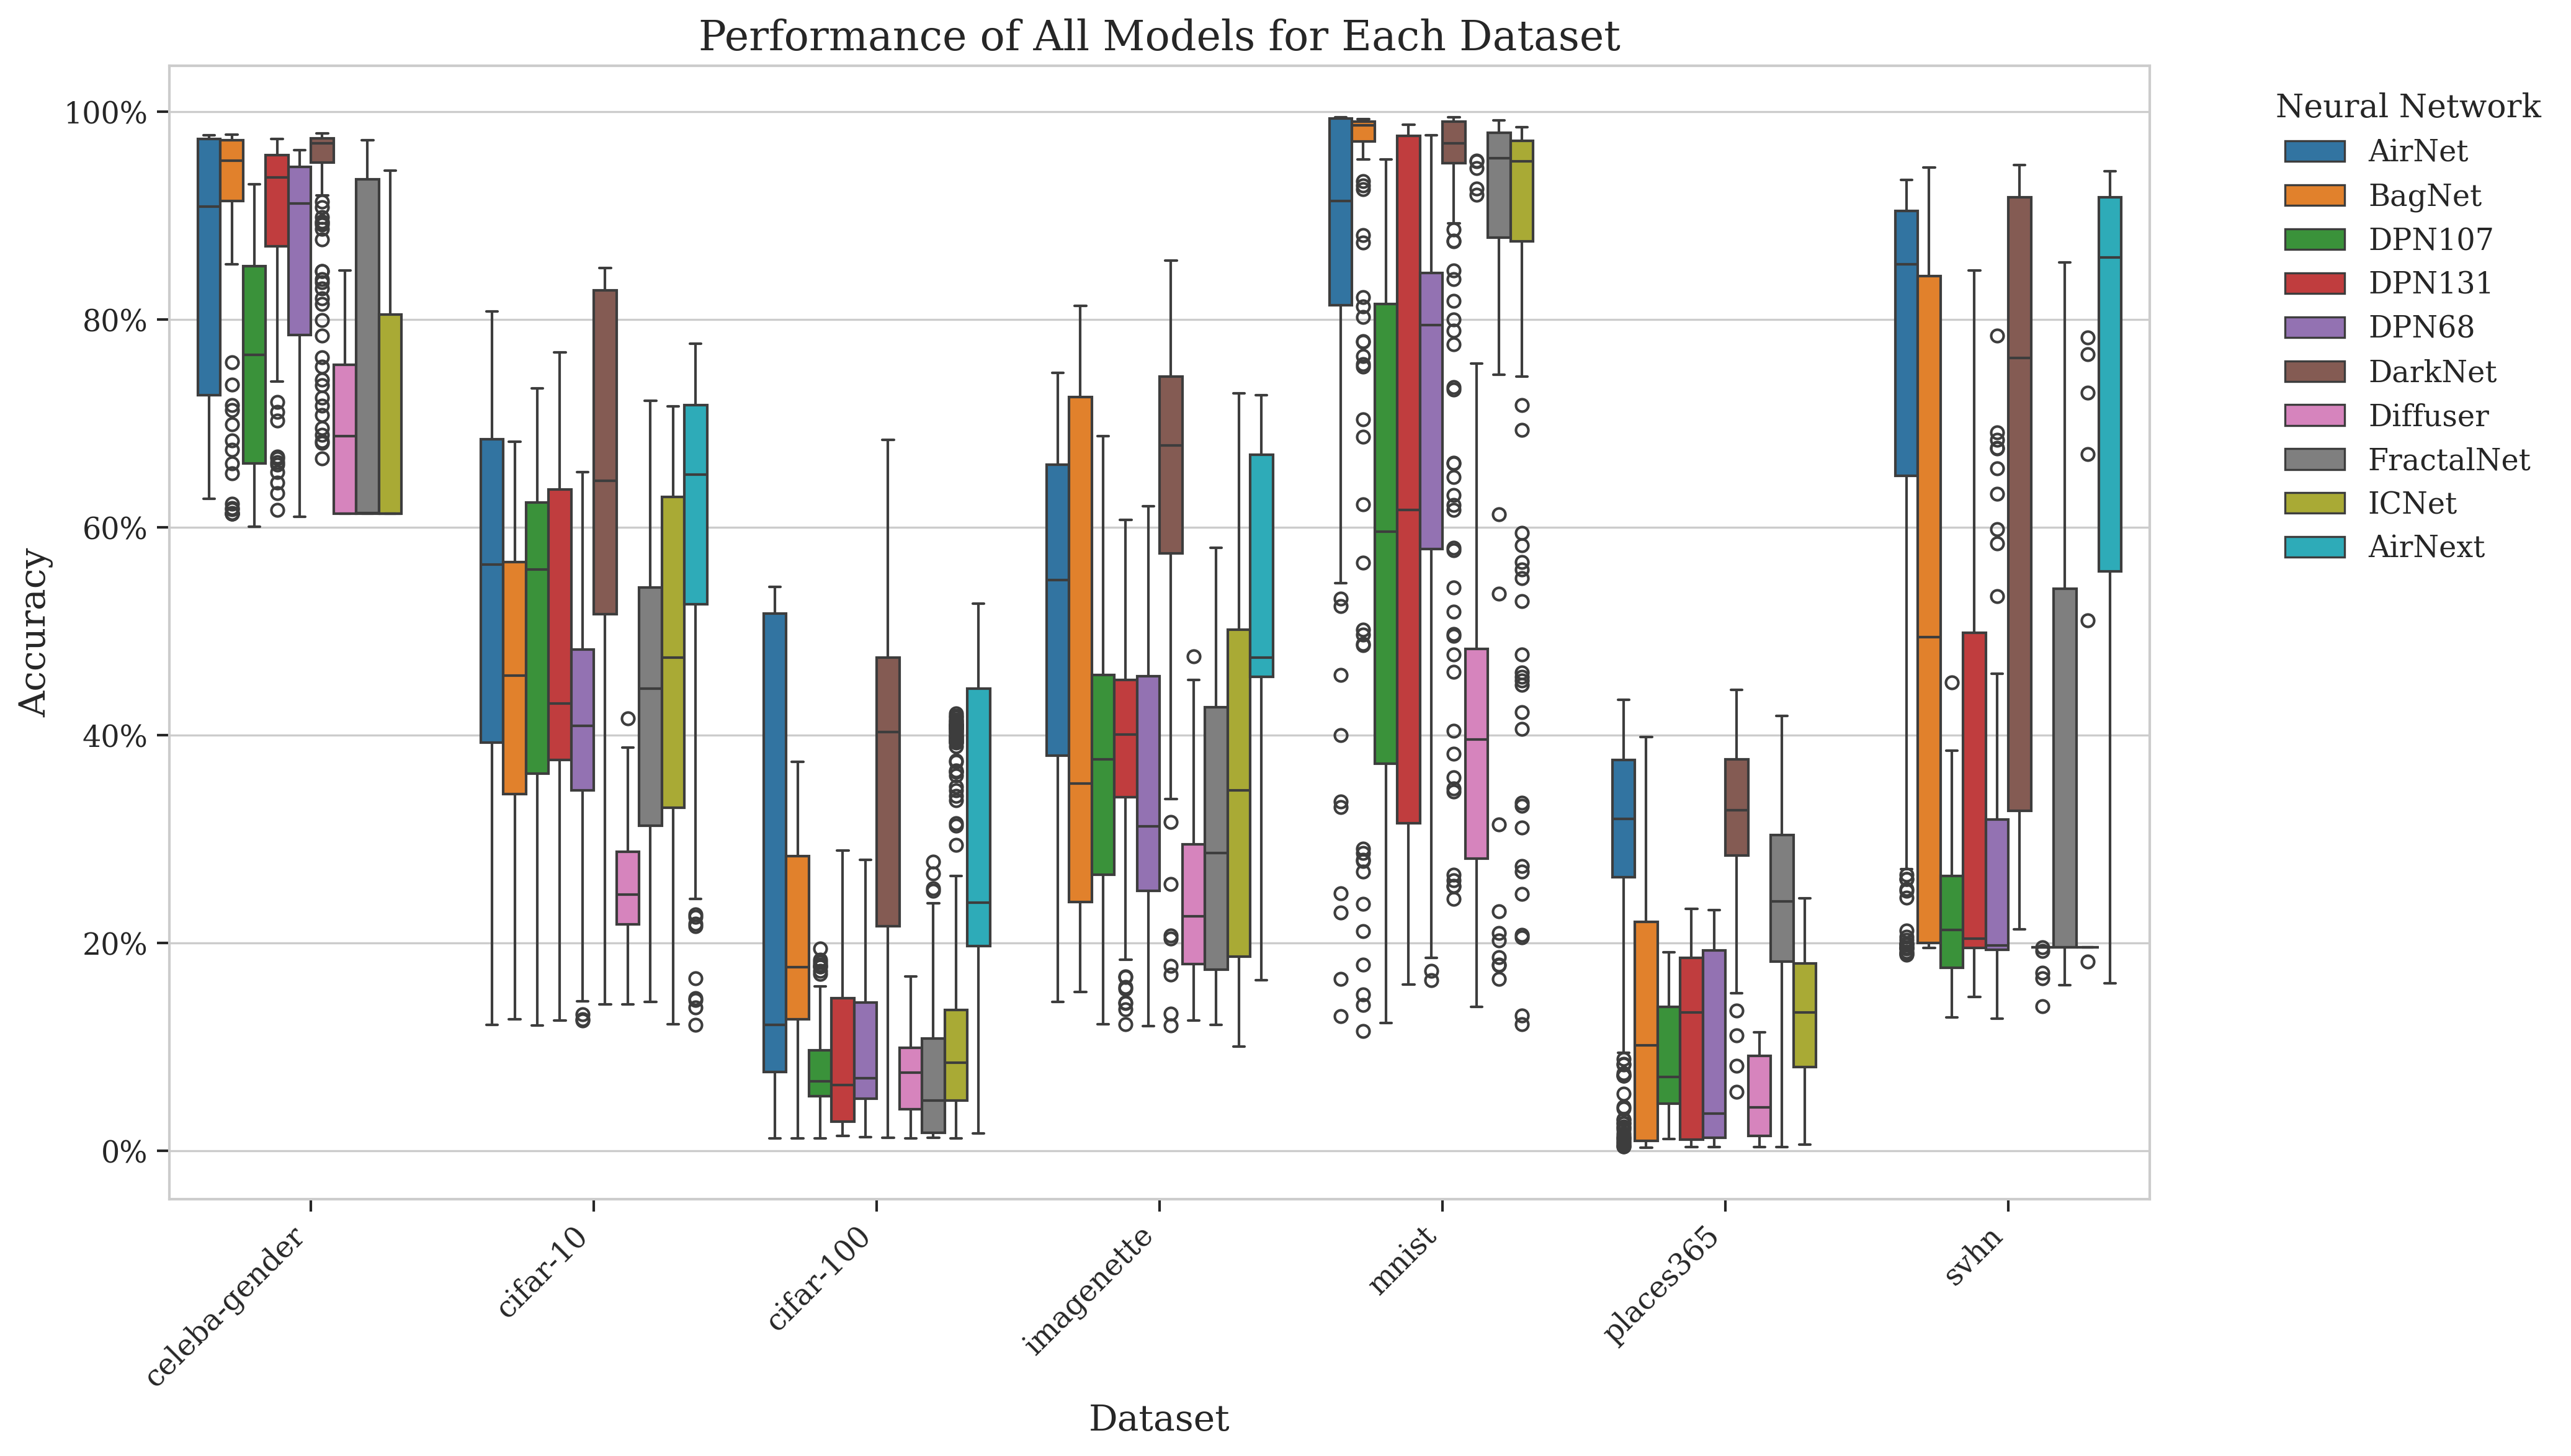

In [11]:

## Visualization 8: All Models Performance for Each Dataset

def create_all_models_performance_visualization():
    print("Creating all models performance visualization...")
    
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(
        x='dataset', 
        y='accuracy', 
        hue='nn', 
        data=filtered_df,
        palette=[model_colors.get(m) for m in relevant_models]
    )
    
    plt.title('Performance of All Models for Each Dataset', fontsize=16)
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage formatting to y-axis
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    plt.legend(title='Neural Network', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(png_dir_stat / 'all_models_performance.png')
    
    # Display the plot in the notebook
    plt.show()

# Run the function to create and display the visualization
create_all_models_performance_visualization()